# Install Library

In [1]:
!pip install -r requirements.txt

# Import Library

In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DateType, FloatType, TimestampNTZType
from matplotlib import pyplot as plt
import ast
import matplotlib.dates as mdates
import numpy as np
from functools import reduce

# Read Dataset using PySpark

In [3]:
spark = SparkSession.builder.config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow").appName('DE Assessment').getOrCreate()

df = spark.read.json("./cc_sample_transaction.json")
df.printSchema()
df.show()

24/10/27 17:42:26 WARN Utils: Your hostname, Goldiuss-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.100.17 instead (on interface en0)
24/10/27 17:42:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/27 17:42:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|             cc_num|is_fraud|  merch_eff_time|merch_las

# Flatten the JSON to Desired DataFrame

## Checking personal detail data

In [4]:
ast.literal_eval(df.select("personal_detail").first()[0])

{'person_name': 'Jennifer,Banks,eeeee',
 'gender': 'F',
 'address': '{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}',
 'lat': '36.0788',
 'long': '-81.1781',
 'city_pop': '3495',
 'job': 'Psychologist, counselling',
 'dob': '1988-03-09'}

## Define Personal Detail JSON Schema

In [5]:
address_schema = StructType([
    StructField("street", StringType(), False),
    StructField("city", StringType(), False),
    StructField("state", StringType(), False),
    StructField("zip", StringType(), False),
])

personal_detail_schema = StructType([
    StructField("person_name", StringType(), False),
    StructField("gender", StringType(), False),
    StructField("address", StringType(), False),
    StructField("lat", StringType(), False),
    StructField("long", StringType(), False),
    StructField("city_pop", StringType(), False),
    StructField("job", StringType(), False),
    StructField("dob", StringType(), False),
])

## Add `first`, `last`, `gender`, `street`, `city`, `state`, `zip`, `lat`, `long`, `city_pop`, `job`, `dob` columns & Delete `personal_detail` column

In [6]:
df = df.withColumn("parsed_detail", F.from_json(F.col("personal_detail"), personal_detail_schema))
df = df.withColumn("parsed_address_detail", F.from_json(F.col("parsed_detail.address"), address_schema))

df = df.withColumn("name", F.col("parsed_detail.person_name"))
df = df.withColumn("first", F.split(F.col("parsed_detail.person_name"), ",")[0])
df = df.withColumn("last", F.split(F.col("parsed_detail.person_name"), ",")[1])
df = df.withColumn("gender", F.col("parsed_detail.gender"))
df = df.withColumn("street", F.col("parsed_address_detail.street"))
df = df.withColumn("city", F.col("parsed_address_detail.city"))
df = df.withColumn("state", F.col("parsed_address_detail.state"))
df = df.withColumn("zip", F.col("parsed_address_detail.zip"))
df = df.withColumn("lat", F.col("parsed_detail.lat"))
df = df.withColumn("long", F.col("parsed_detail.long"))
df = df.withColumn("city_pop", F.col("parsed_detail.city_pop"))
df = df.withColumn("job", F.col("parsed_detail.job"))
df = df.withColumn("dob", F.col("parsed_detail.dob"))

df = df.drop("personal_detail")
df = df.drop("parsed_detail")
df = df.drop("parsed_address_detail")

df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+---------------------+---------+------+------------------------------+------------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |name                     |first                |last     |gender|street                        |city                    |state|zip  |lat    |long              |city_pop|job                                          |dob       |
+----------+------+---

24/10/27 17:42:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Check amt column

### Check whether there is any negative transaction amount as the transaction amount must be 0 or more

In [7]:
print(f"""Number of negative transaction amount: {df.filter(F.col("amt") < 0).count()} data""")

Number of negative transaction amount: 0 data


### Check missing value of transaction amount

In [8]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("amt"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing transaction amount: {missing_count} data")

Number of missing transaction amount: 0 data


There are lots of fraud transactions during the midnight.

### Check whether there is any null transaction amount

In [9]:
print(f"""Number of null transaction amount: {df.filter(F.col("amt").isNull()).count()} data""")

Number of null transaction amount: 0 data


### Check transaction amount distribution

24/10/27 17:42:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


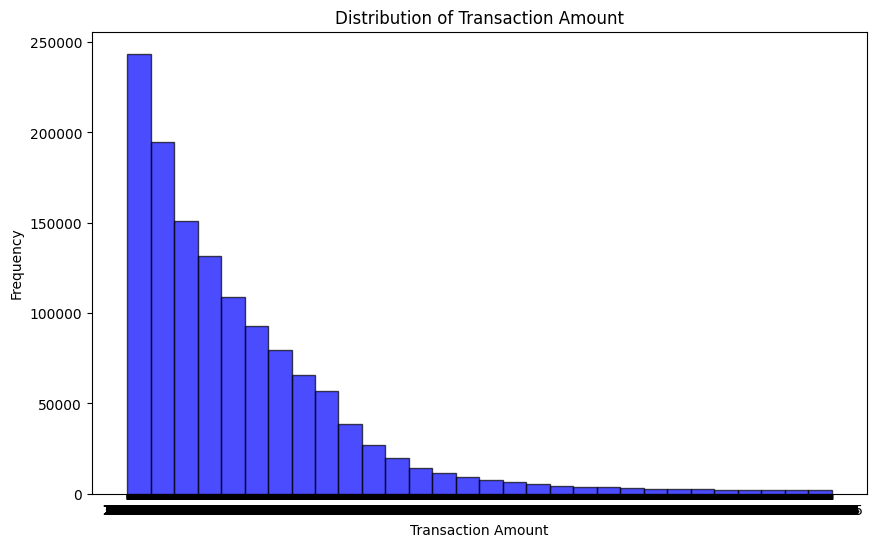

In [10]:
distribution_data = df.select(["amt"]).collect()

values = [row["amt"] for row in distribution_data]

plt.figure(figsize=(10, 6))
plt.hist(values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amount')
plt.show()

Transaction Amount has long tail distribution which is make senses to have more smaller transaction amount compared to the higher transaction amount.

## Check category column

### Check whether there is any null category

In [11]:
print(f"""Number of null category: {df.filter(F.col("category").isNull()).count()} data""")

Number of null category: 0 data


### Check missing value of category

In [12]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("category"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing category: {missing_count} data")

Number of missing category: 0 data


### Check unique value of category

In [13]:
unique_values = df.select("category").distinct().rdd.flatMap(lambda x: x).collect()

print(f"{len(unique_values)} Unique value of 'category' column:")
for unique_value in unique_values:
    print(unique_value)

14 Unique value of 'category' column:
travel
misc_net
grocery_pos
kids_pets
shopping_net
grocery_net
food_dining
gas_transport
personal_care
health_fitness
entertainment
home
misc_pos
shopping_pos


### Check merchant category distribution

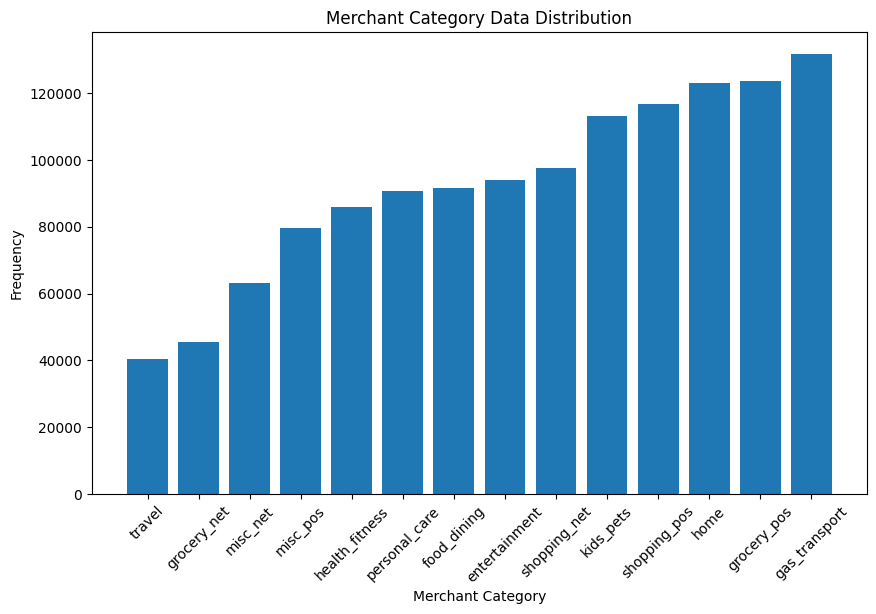

In [14]:
result = df.groupBy("category").count().orderBy("count").collect()

plt.figure(figsize=(10, 6))
plt.bar([res["category"] for res in result], [res["count"] for res in result])

plt.xticks(rotation=45)
plt.xlabel('Merchant Category')
plt.ylabel('Frequency')
plt.title('Merchant Category Data Distribution')

plt.show()

Based on the charts above, a lot of the transaction using credit card comes from gas transport. The lowest transaction comes from travel merchant where we need to create a travel campaign to increase the number of transaction in travel merchant.

## Check cc_bic column

### Check whether there is any null cc_bic

In [15]:
print(f"""Number of null cc_bic: {df.filter(F.col("cc_bic").isNull()).count()} data""")

Number of null cc_bic: 0 data


### Check missing value of cc_bic

In [16]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("cc_bic"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing cc_bic: {missing_count} data")

Number of missing cc_bic: 432980 data


### Check unique value of cc_bic

In [17]:
unique_values = df.select("cc_bic").distinct().rdd.flatMap(lambda x: x).collect()

print(f"{len(unique_values)} Unique value of 'cc_bic' column:")
for unique_value in unique_values:
    print(unique_value)

9 Unique value of 'cc_bic' column:
ADMDUS41
ACEEUS31
DEUTUS33TRF
NA
CITIUS33CHI
AIABUS31

Null
APBCUS61


### Remove empty space string, Null, and NA from cc_bic column

In [18]:
df = df.withColumn(
    "cc_bic",
    F.when(F.col("cc_bic").isNull(), None)
    .when(F.col("cc_bic") == "", None)
    .when(F.col("cc_bic") == "NA", None)
    .when(F.col("cc_bic") == "Null", None)
    .otherwise(F.col("cc_bic"))
)

df = df.dropna(subset=["cc_bic"])

### Check cc_bic distribution

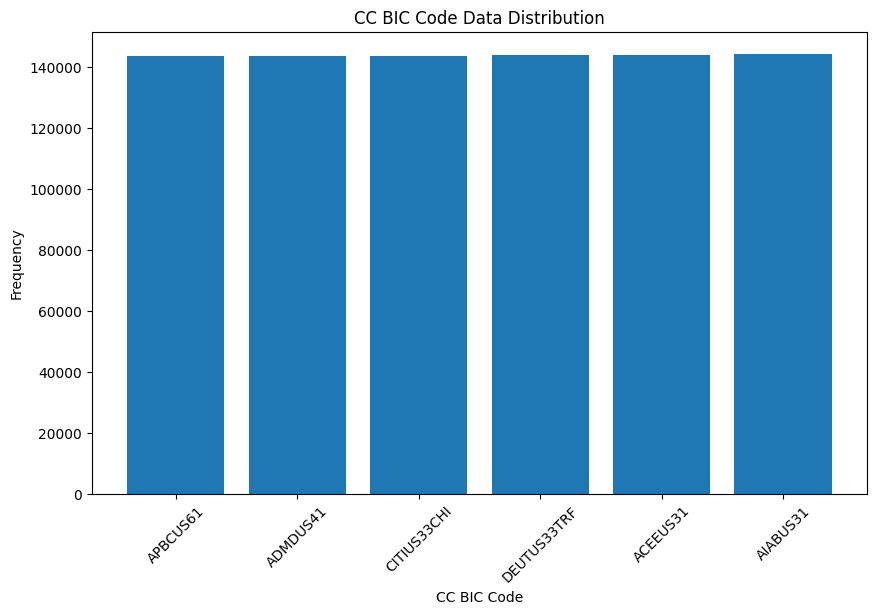

In [19]:
result = df.groupBy("cc_bic").count().orderBy("count").collect()

plt.figure(figsize=(10, 6))
plt.bar([res["cc_bic"] for res in result], [res["count"] for res in result])

plt.xticks(rotation=45)
plt.xlabel('CC BIC Code')
plt.ylabel('Frequency')
plt.title('CC BIC Code Data Distribution')

plt.show()

The distribution of CC BIC code is flat

## Check is_fraud column

### Check whether there is any null is fraud

In [20]:
print(f"""Number of null is fraud: {df.filter(F.col("is_fraud").isNull()).count()} data""")

Number of null is fraud: 0 data


### Check missing value of is_fraud

In [21]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("is_fraud"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing is_fraud: {missing_count} data")

Number of missing is_fraud: 0 data


### Check is fraud distribution

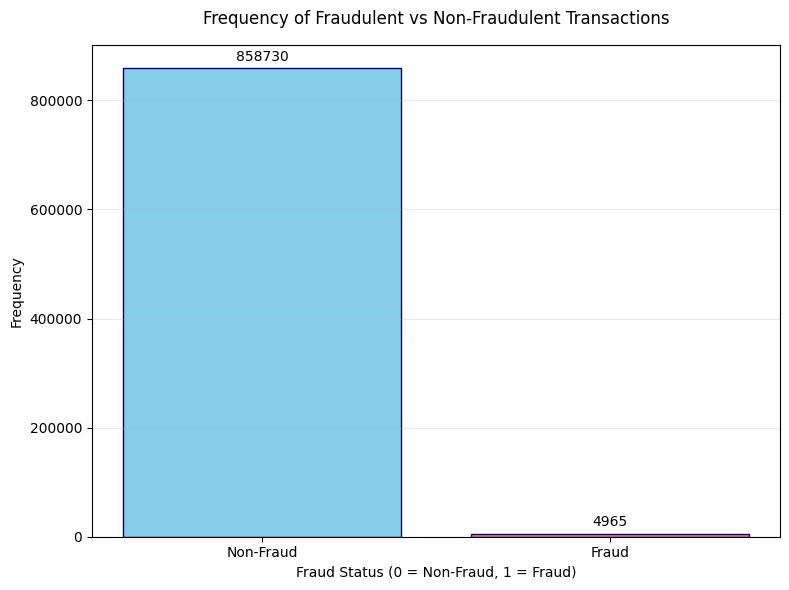

In [22]:
fraud_counts = df.groupBy('is_fraud').count().orderBy('is_fraud').collect()

fraud_labels = [row["is_fraud"] for row in fraud_counts]
counts = [row["count"] for row in fraud_counts]

plt.figure(figsize=(8, 6))
plt.bar(fraud_labels, counts, color=['skyblue', 'salmon'], edgecolor='navy')

plt.title('Frequency of Fraudulent vs Non-Fraudulent Transactions', fontsize=12, pad=15)
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks([0, 1], labels=['Non-Fraud', 'Fraud'])
plt.grid(True, alpha=0.3, axis='y')

for i, count in enumerate(counts):
    plt.text(fraud_labels[i], count + (max(counts) * 0.01), 
             str(count), 
             ha='center', 
             va='bottom')

plt.tight_layout()
plt.show()

According to the 2022 Association of Certified Fraud Examiners (ACFE) report, Credit Card Fraud is one of the most common forms of fraud in banking, with losses estimated to be around 0.1% to 0.3% of total card sales. The fraud credit card transaction rate in our data is 0.57% which is higher than the average credit card fraud rate. 

## Check cc_num column

### Check whether there is any null cc_num

In [23]:
print(f"""Number of null credit card number: {df.filter(F.col("cc_num").isNull()).count()} data""")

Number of null credit card number: 0 data


### Check missing value of cc_num

In [24]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("cc_num"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing cc_num: {missing_count} data")

Number of missing cc_num: 0 data


### Check whether there is any cc_num with non-numerical characters

In [25]:
print(f"""Number of credit card number with non-numerical character: {df.filter(~F.col("cc_num").rlike("^[0-9]+$")).count()} data""")

Number of credit card number with non-numerical character: 0 data


### Check minimum and maximum credit card number length

In [26]:
df.select(F.min(F.length('cc_num')).alias("Minimum Length"), F.max(F.length('cc_num')).alias("Maximum Length"), F.avg(F.length('cc_num')).alias("Average Length"), F.median(F.length('cc_num')).alias("Median Length")).show()

+--------------+--------------+------------------+-------------+
|Minimum Length|Maximum Length|    Average Length|Median Length|
+--------------+--------------+------------------+-------------+
|            11|            19|15.400805840024546|         16.0|
+--------------+--------------+------------------+-------------+



Based on https://en.wikipedia.org/wiki/Payment_card_number

Valid credit card number ranging from 12 to 19. Credit cards with 11 digit card number must be invalid credit card.

### Check distribution based on credit card length

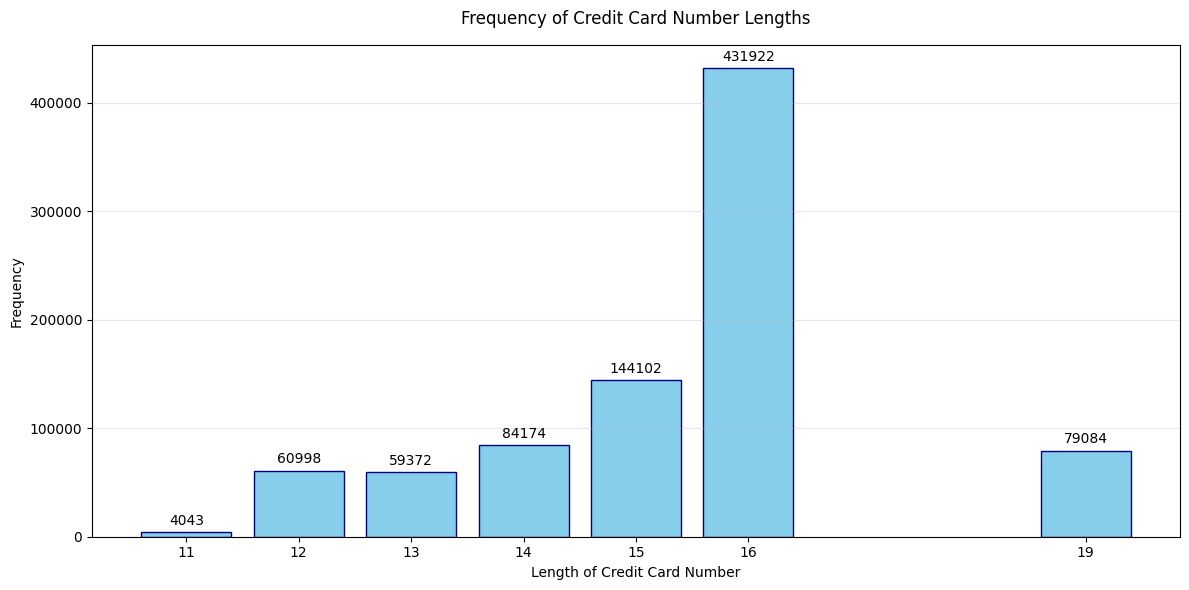

In [27]:
length_counts = df.select(F.length('cc_num').alias('length')) \
                 .groupBy('length') \
                 .count() \
                 .orderBy('length') \
                 .collect()

lengths = [row["length"] for row in length_counts]
counts = [row["count"] for row in length_counts]

plt.figure(figsize=(12, 6))
plt.bar(lengths, counts, color='skyblue', edgecolor='navy')

plt.title('Frequency of Credit Card Number Lengths', fontsize=12, pad=15)
plt.xlabel('Length of Credit Card Number', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

for i, count in enumerate(counts):
    plt.text(lengths[i], count + (max(counts) * 0.01), 
             str(count), 
             ha='center', 
             va='bottom')

plt.xticks(lengths, rotation=0)
plt.tight_layout()
plt.show()

There are 4043 invalid credit card transactions.

### Change data with length of credit card number 11 to is_fraud=1 (true)

In [28]:
df = df.withColumn("is_fraud", F.when(F.length("cc_num") == 11, 1).otherwise(df["is_fraud"]))

### Check distribution of credit card number by fraud status

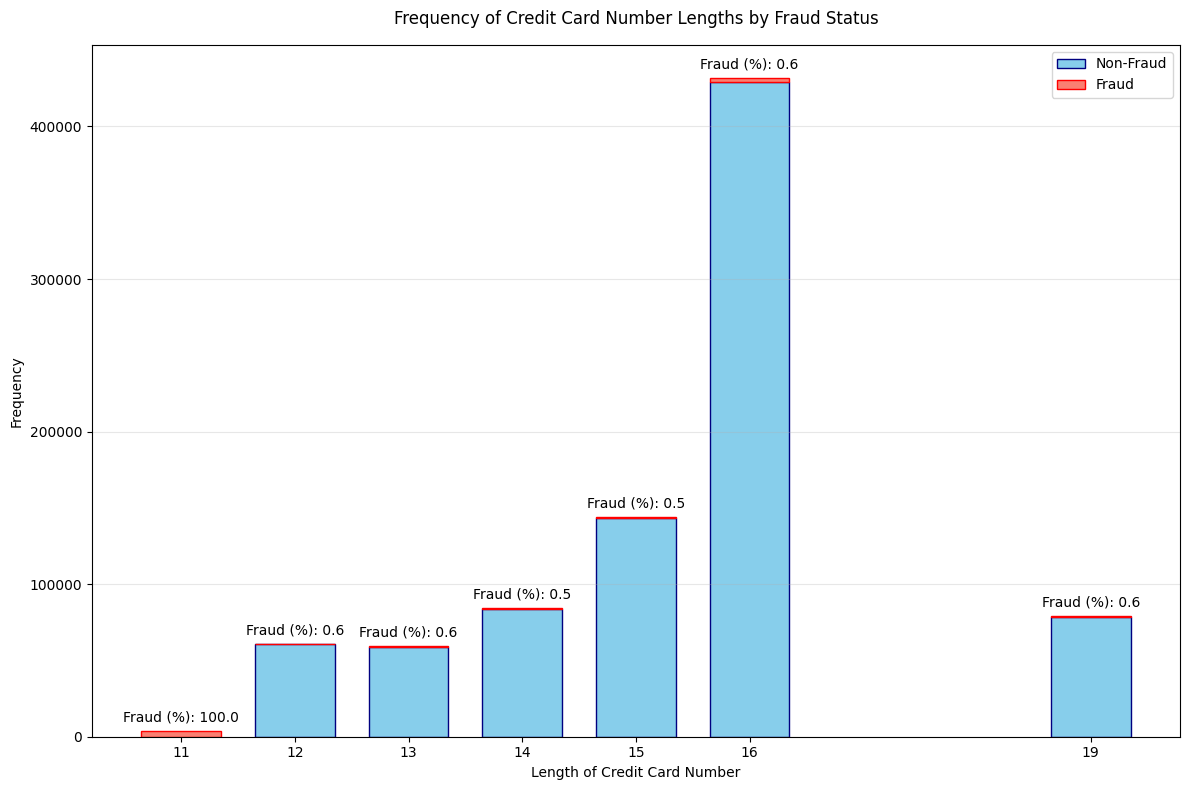

In [29]:
length_fraud_counts = df.groupBy(F.length('cc_num').alias('length'), 'is_fraud') \
                        .count() \
                        .orderBy('length', 'is_fraud') \
                        .collect()

lengths = list(sorted(set([row["length"] for row in length_fraud_counts])))

fraud_counts = {0: [], 1: []}

for length in lengths:
    fraud_counts[0].append(sum([row["count"] for row in length_fraud_counts if row["length"] == length and row["is_fraud"] == '0']))
    fraud_counts[1].append(sum([row["count"] for row in length_fraud_counts if row["length"] == length and row["is_fraud"] == '1']))

fraud_percentages = [100 * fraud_counts[1][i] / (fraud_counts[0][i] + fraud_counts[1][i]) 
                     for i in range(len(lengths))]

plt.figure(figsize=(12, 8))
bar_width = 0.7

p1 = plt.bar(lengths, fraud_counts[0], color='skyblue', edgecolor='navy', label='Non-Fraud', width=bar_width)
p2 = plt.bar(lengths, fraud_counts[1], bottom=fraud_counts[0], color='salmon', edgecolor='red', label='Fraud', width=bar_width)

plt.title('Frequency of Credit Card Number Lengths by Fraud Status', fontsize=12, pad=15)
plt.xlabel('Length of Credit Card Number', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

for i in range(len(lengths)):
    total = fraud_counts[0][i] + fraud_counts[1][i]
    fraud_percentage = fraud_percentages[i]
    plt.text(lengths[i], total + (max(fraud_counts[0]) * 0.01), 
             f'Fraud (%): {fraud_percentage:.1f}', 
             ha='center', 
             va='bottom')

plt.legend()

plt.xticks(lengths, rotation=0)
plt.tight_layout()
plt.show()

The credit card number length which has the highest fraud percentage is 11 digits.

## Check merch_eff_time column

### Check whether there is any null merch_eff_time

In [30]:
print(f"""Number of null merchant effective registration time: {df.filter(F.col("merch_eff_time").isNull()).count()} data""")

Number of null merchant effective registration time: 0 data


### Check missing value of merch_eff_time

In [31]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("merch_eff_time"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merch_eff_time: {missing_count} data")

Number of missing merch_eff_time: 0 data


### Check merch_eff_time length due to unix timestamp format

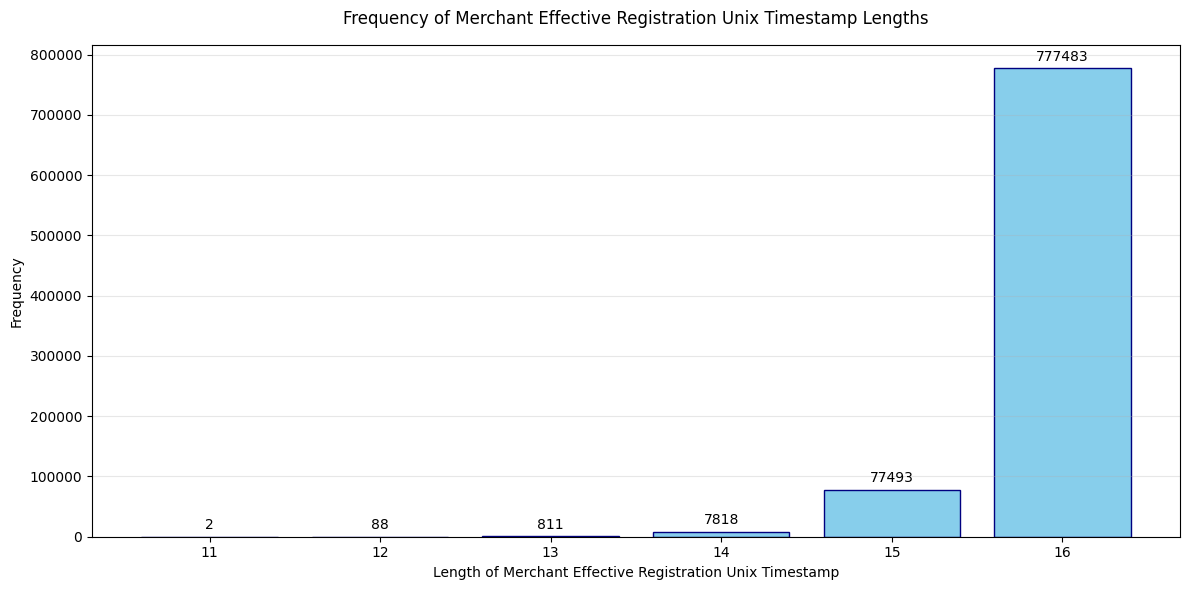

In [32]:
length_counts = df.select(F.length('merch_eff_time').alias('length')) \
                 .groupBy('length') \
                 .count() \
                 .orderBy('length') \
                 .collect()

lengths = [row["length"] for row in length_counts]
counts = [row["count"] for row in length_counts]

plt.figure(figsize=(12, 6))
plt.bar(lengths, counts, color='skyblue', edgecolor='navy')

plt.title('Frequency of Merchant Effective Registration Unix Timestamp Lengths', fontsize=12, pad=15)
plt.xlabel('Length of Merchant Effective Registration Unix Timestamp', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

for i, count in enumerate(counts):
    plt.text(lengths[i], count + (max(counts) * 0.01), 
             str(count), 
             ha='center', 
             va='bottom')

plt.xticks(lengths, rotation=0)
plt.tight_layout()
plt.show()

### Convert merch_eff_time from unix timestamp to date time

In [33]:
output_format = 'yyyy-MM-dd HH:mm:ss.SSSSSS Z'

df = df.withColumn(
    'merch_eff_time',
    F.when(
        F.length(F.col('merch_eff_time').cast("string")) == 10,
        F.date_format(
            F.from_unixtime(F.col('merch_eff_time')),
            output_format
        )
    ).when(
        F.length(F.col('merch_eff_time').cast("string")) > 10,
        F.date_format(
            F.from_unixtime(F.col('merch_eff_time') / pow(10, F.length(F.col('merch_eff_time').cast("string"))-10)),
            output_format
        )
    ).otherwise(None)
)

## Check merch_last_update_time column

### Check whether there is any null merch_last_update_time

In [34]:
print(f"""Number of null merchant last update time: {df.filter(F.col("merch_last_update_time").isNull()).count()} data""")

Number of null merchant last update time: 0 data


### Check missing value of merch_last_update_time

In [35]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("merch_last_update_time"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merch_last_update_time: {missing_count} data")

Number of missing merch_last_update_time: 0 data


### Check merch_last_update_time length due to unix timestamp format

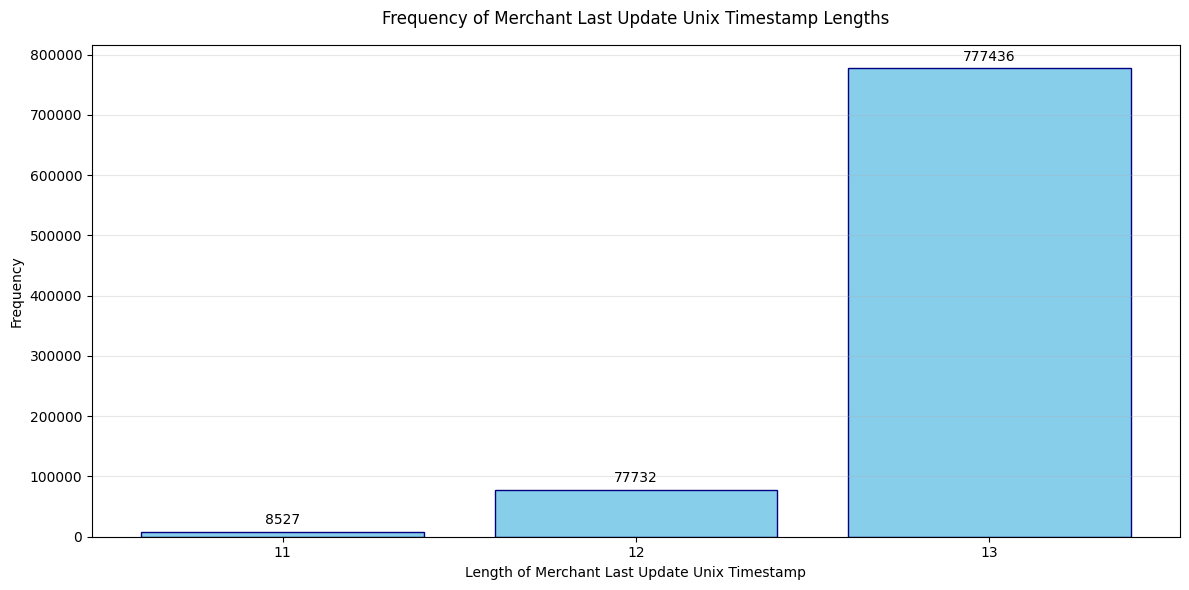

In [36]:
length_counts = df.select(F.length('merch_last_update_time').alias('length')) \
                 .groupBy('length') \
                 .count() \
                 .orderBy('length') \
                 .collect()

lengths = [row["length"] for row in length_counts]
counts = [row["count"] for row in length_counts]

plt.figure(figsize=(12, 6))
plt.bar(lengths, counts, color='skyblue', edgecolor='navy')

plt.title('Frequency of Merchant Last Update Unix Timestamp Lengths', fontsize=12, pad=15)
plt.xlabel('Length of Merchant Last Update Unix Timestamp', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

for i, count in enumerate(counts):
    plt.text(lengths[i], count + (max(counts) * 0.01), 
             str(count), 
             ha='center', 
             va='bottom')

plt.xticks(lengths, rotation=0)
plt.tight_layout()
plt.show()

### Convert merch_eff_time from unix timestamp to date time

In [37]:
output_format = 'yyyy-MM-dd HH:mm:ss.SSSSSS Z'

df = df.withColumn(
    'merch_last_update_time',
    F.when(
        F.length(F.col('merch_last_update_time').cast("string")) == 10,
        F.date_format(
            F.from_unixtime(F.col('merch_last_update_time')),
            output_format
        )
    ).when(
        F.length(F.col('merch_last_update_time').cast("string")) > 10,
        F.date_format(
            F.from_unixtime(F.col('merch_last_update_time') / pow(10, F.length(F.col('merch_last_update_time').cast("string"))-10)),
            output_format
        )
    ).otherwise(None)
)

### Check whether merchant effective registration time is always less than equal to merchant last update time

In [38]:
print(f"""Number of rows where merch_eff_time > merch_last_update_time: {df.filter(F.col("merch_eff_time") > F.col("merch_last_update_time")).count()} data""")

Number of rows where merch_eff_time > merch_last_update_time: 0 data


## Check merch_lat column

### Check whether there is any null merch_lat

In [39]:
print(f"""Number of null merchant latitude: {df.filter(F.col("merch_lat").isNull()).count()} data""")

Number of null merchant latitude: 0 data


### Check missing value of merch_lat

In [40]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("merch_lat"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merch_lat: {missing_count} data")

Number of missing merch_lat: 0 data


### Check for invalid merchant latitude (less than -90 or more than 90)

In [41]:
print(f"""Number of invalid merchant latitude: {df.filter((F.col("merch_lat") < -90) | (F.col("merch_lat") > 90)).count()} data""")

Number of invalid merchant latitude: 0 data


### Check for non-numeric characters, except for dot and negative sign in merchant latitude

In [42]:
invalid_count = df.filter(~F.col('merch_lat').rlike('^-?\\d*\\.?\\d+$')).count()

print(f"Number of merchant latitude with invalid characters: {invalid_count} data")

Number of merchant latitude with invalid characters: 0 data


## Check merch_long column

### Check whether there is any null merch_long

In [43]:
print(f"""Number of null merchant longitude: {df.filter(F.col("merch_long").isNull()).count()} data""")

Number of null merchant longitude: 0 data


### Check missing value of merch_long

In [44]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("merch_long"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merch_long: {missing_count} data")

Number of missing merch_long: 0 data


### Check for invalid merchant longitude (less than -180 or more than 180)

In [45]:
print(f"""Number of invalid merchant longitude: {df.filter((F.col("merch_long") < -180) | (F.col("merch_long") > 180)).count()} data""")

Number of invalid merchant longitude: 0 data


### Check for non-numeric characters, except for dot and negative sign in merchant longitude

In [46]:
invalid_count = df.filter(~F.col("merch_long").rlike("^-?\\d*\\.?\\d+$")).count()

print(f"Number of merchant longitude with invalid characters: {invalid_count} data")

Number of merchant longitude with invalid characters: 0 data


## Check merch_zipcode column

### Check whether there is any null merch_zipcode

In [47]:
print(f"""Number of null merchant zipcode: {df.filter(F.col("merch_zipcode").isNull()).count()} data""")

Number of null merchant zipcode: 130597 data


### Fill null with empty string

In [48]:
df = df.na.fill("")

### Check missing value of merch_zipcode

In [49]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan"]

conditions = [
    (F.lower(F.trim(F.col("merch_zipcode"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merch_zipcode: {missing_count} data")

Number of missing merch_zipcode: 0 data


### Check whether there is any merch_zipcode with non-numerical characters

In [50]:
print(f"""Number of merch zipcode with non-numerical character: {df.filter(~F.col("merch_zipcode").rlike("^[0-9]+$")).count()} data""")

Number of merch zipcode with non-numerical character: 130597 data


### Check minimum and maximum merchant zipcode length

In [51]:
df.select(F.min(F.length('merch_zipcode')).alias("Minimum Length"), F.max(F.length('merch_zipcode')).alias("Maximum Length"), F.avg(F.length('merch_zipcode')).alias("Average Length"), F.median(F.length('merch_zipcode')).alias("Median Length")).show()

+--------------+--------------+-----------------+-------------+
|Minimum Length|Maximum Length|   Average Length|Median Length|
+--------------+--------------+-----------------+-------------+
|             0|             5|4.243963436166703|          5.0|
+--------------+--------------+-----------------+-------------+



In [52]:
unique_lengths_df = df.select(F.length('merch_zipcode').alias("Length")).distinct().show()

+------+
|Length|
+------+
|     5|
|     0|
+------+



## Check merchant column

### Check whether there is any null merchant

In [53]:
print(f"""Number of null merchant: {df.filter(F.col("merchant").isNull()).count()} data""")

Number of null merchant: 0 data


### Check missing value of merchant

In [54]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("merchant"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing merchant: {missing_count} data")

Number of missing merchant: 0 data


### Check merch_eff_time consistency for each merchant

In [55]:
location_inconsistencies = df.withColumn(
    "location_composite", 
    F.struct(
        "merch_lat", 
        "merch_long", 
        "merch_zipcode"
    )
)

same_time_inconsistencies = location_inconsistencies.groupBy(
    "merchant", 
    "merch_last_update_time"
).agg(
    F.countDistinct("location_composite").alias("location_versions_count")
).filter(
    F.col("location_versions_count") > 1
)

inconsistent_merchants = same_time_inconsistencies.select("merchant").distinct()

df.join(
    inconsistent_merchants,
    "merchant",
    "inner"
).orderBy(
    "merchant",
    "merch_last_update_time"
).show(truncate=False)

+---------------------------------+----------+------+--------+-----------+-------------------+--------+--------------------------------+--------------------------------+------------------+------------------+-------------+---------------------+--------------------------------+------------------------------+-----------------+-----------+------+----------------------------+---------------+-----+-----+------------------+---------+--------+-----------------------------------+----------+
|merchant                         |Unnamed: 0|amt   |category|cc_bic     |cc_num             |is_fraud|merch_eff_time                  |merch_last_update_time          |merch_lat         |merch_long        |merch_zipcode|trans_date_trans_time|trans_num                       |name                          |first            |last       |gender|street                      |city           |state|zip  |lat               |long     |city_pop|job                                |dob       |
+-------------------------

We can see that the merch_eff_time are different for the same merchant. The same merchant must have the same effective registration time. Therefore, we will set the merch_eff_time to the minimum merch_eff_time for each merchant.

### Standardize merch_eff_time for each merchant through setting it with minimum merch_eff_time

In [56]:
min_eff_times = df.groupBy("merchant").agg(
    F.min("merch_eff_time").alias("min_merch_eff_time")
)

standardized_df = df.join(
    min_eff_times,
    "merchant",
    "left"
)

all_columns = df.columns
select_columns = []

for column in all_columns:
    if column == "merch_eff_time":
        select_columns.append(F.col("min_merch_eff_time").alias("merch_eff_time"))
    else:
        select_columns.append(F.col(column))

df = standardized_df.select(*select_columns)

## Check trans_date_trans_time column

### Check whether there is any null trans_date_trans_time

In [57]:
print(f"""Number of null transaction date time: {df.filter(F.col("trans_date_trans_time").isNull()).count()} data""")

Number of null transaction date time: 0 data


### Check missing value of trans_date_trans_time

In [58]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("trans_date_trans_time"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing trans_date_trans_time: {missing_count} data")

Number of missing trans_date_trans_time: 0 data


### Check whether merchant effective registration time is always less than equal to transaction date time

In [59]:
print(f"""Number of rows where trans_date_trans_time < merch_last_update_time: {df.filter(F.col("trans_date_trans_time") < F.col("merch_last_update_time")).count()} data""")

Number of rows where trans_date_trans_time < merch_last_update_time: 0 data


## Check trans_num column

### Check whether there is any null trans_num

In [60]:
print(f"""Number of null transaction number: {df.filter(F.col("trans_num").isNull()).count()} data""")

Number of null transaction number: 0 data


### Check missing value of trans_num

In [61]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("trans_num"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing trans_num: {missing_count} data")

Number of missing trans_num: 0 data


### Check minimum and maximum transaction number length

In [62]:
df.select(F.min(F.length('trans_num')).alias("Minimum Length"), F.max(F.length('trans_num')).alias("Maximum Length"), F.avg(F.length('trans_num')).alias("Average Length"), F.median(F.length('trans_num')).alias("Median Length")).show()

+--------------+--------------+--------------+-------------+
|Minimum Length|Maximum Length|Average Length|Median Length|
+--------------+--------------+--------------+-------------+
|            32|            32|          32.0|         32.0|
+--------------+--------------+--------------+-------------+



Transaction number always contains 32 digits which indicates consistency and validity of the transaction number.

## Check name column

In [63]:
df.show(20, truncate=False)

+----------+------+-------------+-----------+-------------------+--------+--------------------------------+--------------------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+-----------------+-------+------+------------------------------+-------------------+-----+-----+-------+------------------+--------+---------------------------------------------+----------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time                  |merch_last_update_time          |merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |name                     |first            |last   |gender|street                        |city               |state|zip  |lat    |long              |city_pop|job                                          |dob 

### Remove any special characters based on patterns found

Name Pattern:
- "Doe, John"
- "Doe, John @example.com"
- "Smith, Jane!!!"
- "Johnson | Mary"
- "Brown, | James /"
- "Taylor!  ,  Chris"

In [64]:
df = df.withColumn(
    "name",
    F.trim(F.concat_ws(" ", F.split("name", ",")[0], F.split("name", ",")[1]))
).withColumn(
    "name",
    F.trim(F.concat_ws(" ", F.split("name", ",")[0], F.split("name", ",")[1]))
).withColumn(
    "name",
    F.trim(F.regexp_replace("name", "@", " "))
).withColumn(
    "name", F.trim(F.regexp_replace(F.regexp_replace("name", "\\|", " "), "!!!", ""))
).withColumn(
    "name",
    F.trim(F.regexp_replace(F.regexp_replace("name", "/", " "), " !", ""))
).withColumn(
    "name",
    F.trim(F.regexp_replace("name", r"\s+", " "))
)

### Check whether the name still contains any special characters

In [65]:
df.filter(F.col("name").rlike("[^a-zA-Z ]")).show(50, truncate=False)

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+----+-----+----+------+------+----+-----+---+---+----+--------+---+---+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|name|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+----+-----+----+------+------+----+-----+---+---+----+--------+---+---+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+----+-----+----+------+------+----+-----+---+---+----+--------+---+---+



### Split name to first and last name

In [66]:
df = df.withColumn("first", F.split(F.col("name"), " ")[0])
df = df.withColumn("last", F.split(F.col("name"), " ")[1]).fillna("")

### Check whether there is null first name

In [67]:
print(f"""Number of null first name: {df.filter(F.col("first").isNull()).count()} data""")

Number of null first name: 0 data


### Check missing value of first name

In [68]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("first"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing first name: {missing_count} data")

Number of missing first name: 0 data


### Check whether there is null last name

In [69]:
print(f"""Number of null last name: {df.filter(F.col("last").isNull()).count()} data""")

Number of null last name: 0 data


### Check missing value of last name

In [70]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan"]

conditions = [
    (F.lower(F.trim(F.col("last"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing last name: {missing_count} data")

Number of missing last name: 0 data


### Remove name column

In [71]:
df = df.drop("name")

## Check gender column

### Check whether there is any null gender

In [72]:
print(f"""Number of null gender: {df.filter(F.col("gender").isNull()).count()} data""")

Number of null gender: 0 data


### Check missing value of gender

In [73]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("gender"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing gender: {missing_count} data")

Number of missing gender: 0 data


### Check gender value validity "M" or "F"

In [74]:
invalid_gender = df.filter(
    ~F.col("gender").isin(["M", "F"])
).count()

print(f"Number of invalid gender: {invalid_gender} data")

Number of invalid gender: 0 data


### Replace gender with Male and Female

In [75]:
df = df.withColumn(
    "gender",
    F.when(F.col("gender") == "M", "Male")
     .when(F.col("gender") == "F", "Female")
     .otherwise(F.col("gender"))
)

## Check street column

### Check whether there is any null street

In [76]:
print(f"""Number of null street: {df.filter(F.col("street").isNull()).count()} data""")

Number of null street: 0 data


### Check missing value of street

In [77]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("street"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing street: {missing_count} data")

Number of missing street: 0 data


### Check street which doesn't match to the pattern

Pattern: [street_number] [street_name] [optional_apt_or_suite_information]

- Street number (1 to 5 digits)
- Street name (only letters and spaces)
- Apt or Suite info (Optional)

In [78]:
street_number_pattern = r'^\d{1,5}'
street_name_pattern = r'[A-Za-z\s]+'
optional_suite_apt_pattern = r'(Apt\.|Suite)\s\d+'

full_pattern = f"{street_number_pattern} {street_name_pattern}( {optional_suite_apt_pattern})?"

invalid_data = df.filter(
    ~F.col("street").rlike(full_pattern)
).count()

print(f"Number of invalid street: {invalid_data} data")

Number of invalid street: 0 data


## Check city column

### Check whether there is any null city

In [79]:
print(f"""Number of null city: {df.filter(F.col("city").isNull()).count()} data""")

Number of null city: 0 data


### Check missing value of city

In [80]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("city"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing city: {missing_count} data")

Number of missing city: 0 data


## Check state column

### Check whether there is any null state

In [81]:
print(f"""Number of null state: {df.filter(F.col("state").isNull()).count()} data""")

Number of null state: 0 data


### Check missing value of state

In [82]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("state"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing state: {missing_count} data")

Number of missing state: 0 data


### Check invalid state

In [83]:
invalid_state = df.filter(~F.col("state").rlike("^[A-Z]{2}$")).count()

print(f"Number of invalid state: {invalid_state} data")

Number of invalid state: 0 data


## Check zip column

### Check whether there is any null zipcode

In [84]:
print(f"""Number of null zipcode: {df.filter(F.col("zip").isNull()).count()} data""")

Number of null zipcode: 0 data


### Check missing value of zipcode

In [85]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("zip"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing zip: {missing_count} data")

Number of missing zip: 0 data


### Check whether there is any zipcode with non-numerical characters

In [86]:
print(f"""Number of zipcode with non-numerical character: {df.filter(~F.col("zip").rlike("^[0-9]+$")).count()} data""")

Number of zipcode with non-numerical character: 0 data


### Check minimum and maximum merchant zipcode length

In [87]:
df.select(F.min(F.length('zip')).alias("Minimum Length"), F.max(F.length('zip')).alias("Maximum Length"), F.avg(F.length('zip')).alias("Average Length"), F.median(F.length('zip')).alias("Median Length")).show()

+--------------+--------------+-----------------+-------------+
|Minimum Length|Maximum Length|   Average Length|Median Length|
+--------------+--------------+-----------------+-------------+
|             4|             5|4.936797133247269|          5.0|
+--------------+--------------+-----------------+-------------+



There are no zipcodes with 4 digits and should be removed from the data.

### Remove data with 4 digit zipcode

In [88]:
df = df.filter(F.length('zip') != 4)

In [89]:
df.select(F.min(F.length('zip')).alias("Minimum Length"), F.max(F.length('zip')).alias("Maximum Length"), F.avg(F.length('zip')).alias("Average Length"), F.median(F.length('zip')).alias("Median Length")).show()

+--------------+--------------+--------------+-------------+
|Minimum Length|Maximum Length|Average Length|Median Length|
+--------------+--------------+--------------+-------------+
|             5|             5|           5.0|          5.0|
+--------------+--------------+--------------+-------------+



## Check lat column

### Check whether there is any null lat

In [90]:
print(f"""Number of null latitude: {df.filter(F.col("lat").isNull()).count()} data""")

Number of null latitude: 0 data


### Check missing value of lat

In [91]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("lat"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing lat: {missing_count} data")

Number of missing lat: 0 data


### Check for invalid latitude (less than -90 or more than 90)

In [92]:
print(f"""Number of invalid latitude: {df.filter((F.col("lat") < -90) | (F.col("lat") > 90)).count()} data""")

Number of invalid latitude: 0 data


### Check for non-numeric characters, except for dot and negative sign in latitude

In [93]:
invalid_count = df.filter(~F.col('lat').rlike('^-?\\d*\\.?\\d+$')).count()

print(f"Number of latitude with invalid characters: {invalid_count} data")

Number of latitude with invalid characters: 0 data


## Check long column

### Check whether there is any null longitude

In [94]:
print(f"""Number of null longitude: {df.filter(F.col("long").isNull()).count()} data""")

Number of null longitude: 0 data


### Check missing value of longitude

In [95]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("long"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing long: {missing_count} data")

Number of missing long: 0 data


### Check for invalid longitude (less than -180 or more than 180)

In [96]:
print(f"""Number of invalid longitude: {df.filter((F.col("long") < -180) | (F.col("long") > 180)).count()} data""")

Number of invalid longitude: 0 data


### Check for non-numeric characters, except for dot and negative sign in longitude

In [97]:
invalid_count = df.filter(~F.col("long").rlike("^-?\\d*\\.?\\d+$")).count()

print(f"Number of longitude with invalid characters: {invalid_count} data")

Number of longitude with invalid characters: 0 data


## Check city_pop column

### Check for non-numerical city_pop

In [98]:
non_numeric_city_pop = df.filter(~F.col("city_pop").rlike("^[0-9]+$")).count()

print(f"Number of non-numeric city_pop: {non_numeric_city_pop} data")

Number of non-numeric city_pop: 0 data


## Check job column

### Check whether there is any null job

In [99]:
print(f"""Number of null job: {df.filter(F.col("job").isNull()).count()} data""")

Number of null job: 0 data


### Check missing value of job

In [100]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("job"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing job: {missing_count} data")

Number of missing job: 0 data


## Check dob column

### Check whether there is any null dob

In [101]:
print(f"""Number of null dob: {df.filter(F.col("dob").isNull()).count()} data""")

Number of null dob: 0 data


### Check missing value of dob

In [102]:
missing_indicators = ["n/a", "na", "-", "undefined", "none", "missing", "null", "nan", ""]

conditions = [
    (F.lower(F.trim(F.col("dob"))) == indicator) 
    for indicator in missing_indicators
]

combined_condition = reduce(lambda a, b: a | b, conditions)

missing_count = df.select(
    F.sum(F.when(combined_condition, 1).otherwise(0)).alias('count')
).collect()[0]['count']

print(f"Number of missing dob: {missing_count} data")

Number of missing dob: 0 data


### Check invalid dob

Valid DOB format: yyyy-MM-dd

In [103]:
date_pattern = r"^\d{4}-\d{2}-\d{2}$"

invalid_dob = df.filter(
    ~F.col("dob").rlike(date_pattern) | F.to_date(F.col("dob"), "yyyy-MM-dd").isNull()
).count()

print(f"Number of invalid dob: {invalid_dob} data")

Number of invalid dob: 0 data


## Check the Final Data Before Processing PII Data

In [104]:
df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+--------------------------------+--------------------------------+------------------+------------------+-------------+---------------------------------+---------------------+--------------------------------+---------+--------+------+-------------------------------+--------------+-----+-----+-------+---------+--------+----------------------------+----------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time                  |merch_last_update_time          |merch_lat         |merch_long        |merch_zipcode|merchant                         |trans_date_trans_time|trans_num                       |first    |last    |gender|street                         |city          |state|zip  |lat    |long     |city_pop|job                         |dob       |
+----------+------+-------------+-----------+-------------------+--------+--------------------------------+-------------------------

## Convert Data Type

In [105]:
df.printSchema()

root
 |-- Unnamed: 0: string (nullable = false)
 |-- amt: string (nullable = false)
 |-- category: string (nullable = false)
 |-- cc_bic: string (nullable = false)
 |-- cc_num: string (nullable = false)
 |-- is_fraud: string (nullable = false)
 |-- merch_eff_time: string (nullable = false)
 |-- merch_last_update_time: string (nullable = false)
 |-- merch_lat: string (nullable = false)
 |-- merch_long: string (nullable = false)
 |-- merch_zipcode: string (nullable = false)
 |-- merchant: string (nullable = false)
 |-- trans_date_trans_time: string (nullable = false)
 |-- trans_num: string (nullable = false)
 |-- first: string (nullable = false)
 |-- last: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- street: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- zip: string (nullable = false)
 |-- lat: string (nullable = false)
 |-- long: string (nullable = false)
 |-- city_pop: string (nullable = false)
 |-- job

In [106]:
df = df.withColumn("amt", F.col("amt").cast(FloatType()))
df = df.withColumn("is_fraud", F.col("is_fraud").cast(BooleanType()))
df = df.withColumn("merch_eff_time", F.col("merch_eff_time").cast(TimestampNTZType()))
df = df.withColumn("merch_last_update_time", F.col("merch_last_update_time").cast(TimestampNTZType()))
df = df.withColumn("merch_lat", F.col("merch_lat").cast(FloatType()))
df = df.withColumn("merch_long", F.col("merch_long").cast(FloatType()))
df = df.withColumn("trans_date_trans_time", F.col("trans_date_trans_time").cast(TimestampNTZType()))
df = df.withColumn("lat", F.col("lat").cast(FloatType()))
df = df.withColumn("long", F.col("long").cast(FloatType()))
df = df.withColumn("city_pop", F.col("city_pop").cast(IntegerType()))
df = df.withColumn("dob", F.col("dob").cast(DateType()))

In [107]:
df.printSchema()

root
 |-- Unnamed: 0: string (nullable = false)
 |-- amt: float (nullable = true)
 |-- category: string (nullable = false)
 |-- cc_bic: string (nullable = false)
 |-- cc_num: string (nullable = false)
 |-- is_fraud: boolean (nullable = true)
 |-- merch_eff_time: timestamp_ntz (nullable = true)
 |-- merch_last_update_time: timestamp_ntz (nullable = true)
 |-- merch_lat: float (nullable = true)
 |-- merch_long: float (nullable = true)
 |-- merch_zipcode: string (nullable = false)
 |-- merchant: string (nullable = false)
 |-- trans_date_trans_time: timestamp_ntz (nullable = true)
 |-- trans_num: string (nullable = false)
 |-- first: string (nullable = false)
 |-- last: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- street: string (nullable = false)
 |-- city: string (nullable = false)
 |-- state: string (nullable = false)
 |-- zip: string (nullable = false)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- city_pop: integer (nullable = true)


## Add Features to Dataset

### Add transaction date, transaction hour, transaction month, transaction day of week, transaction distance columns

In [108]:
df = df.withColumn("trans_date_trans_time", F.to_timestamp("trans_date_trans_time")) \
    .withColumn("transaction_date", F.date_format("trans_date_trans_time", "yyyy-MM-dd")) \
    .withColumn("transaction_hour", F.date_format("trans_date_trans_time", "HH")) \
    .withColumn("transaction_month", F.date_format("trans_date_trans_time", "MM")) \
    .withColumn("transaction_day_of_week", F.dayofweek("trans_date_trans_time"))

df = df.withColumn("transaction_longitude_distance", F.col("merch_long") - F.col("long")) \
    .withColumn("transaction_latitude_distance", F.col("merch_lat") - F.col("lat")) \
    .withColumn("transaction_distance", F.sqrt(F.pow(F.col("transaction_longitude_distance"), 2) + F.pow(F.col("transaction_latitude_distance"), 2)))

## Mask PII Data

#### PII columns:
- cc_num (source: https://www.moneris.com/help/6200/masking.htm#:~:text=%5BCardholder%20copy%5D%20The%20card%20number%20will%20appear%20masked%20as%201234567891,and%20no%20Expiry%20date%20appears.)
- cc_bic (source: https://verified-data.com/pii-reference-guide/)
- trans_num (source: https://dpcld.defense.gov/Privacy/About-the-Office/FAQs/#:~:text=Examples%20of%20personally%20identifiable%20information%20(PII)%20include%20%3A,Personal%20address%20and%20phone%20number)
- first (source: https://www.cloudflare.com/en-gb/learning/privacy/what-is-pii/)
- last (source: https://www.cloudflare.com/en-gb/learning/privacy/what-is-pii/)
- street (source: https://www.cloudflare.com/en-gb/learning/privacy/what-is-pii/)
- lat (source: https://learn.microsoft.com/en-us/windows-hardware/drivers/gnss/privacy-and-security-in-the-sensor-and-location-platform)
- long (source: https://learn.microsoft.com/en-us/windows-hardware/drivers/gnss/privacy-and-security-in-the-sensor-and-location-platform)

#### Data Encryption

- cc_num
- cc_bic
- trans_num

Data Encryption using SHA256 is chosen for these three columns as you want to revisit the value when it is required through opening the hash to value mapping.

#### Anonymization

- first
- last
- street
- zip

Anonymization method is chosen for these four columns as it is not required to revisit the values if anything happened.

Binning Method (round off to 1 decimal to reduce location accuracy):
- lat
- long

#### Data Minimization

- dob (to age)

Avoid raw date of birth shown by converting it to age which will be more beneficial for analytics.

In [109]:
def mask_pii(df):
    def hash_value(col_name):
        return F.sha2(F.col(col_name), 256)
    
    def mask_string(col_name, front=1):
        # Masking function to keep 'front' characters visible, replacing the rest with '*'
        def mask(value):
            return value[:front] + '*' * (len(value) - front) if value else None
        return F.udf(mask, StringType())(F.col(col_name))
    
    def bin_coordinates(col_name):
        return F.round(F.col(col_name), 1)
    
    masked_df = df.withColumn(
        'cc_num', hash_value('cc_num')
    ).withColumn(
        'cc_bic', hash_value('cc_bic')
    ).withColumn(
        'trans_num', hash_value('trans_num')
    ).withColumn(
        'first', mask_string('first')
    ).withColumn(
        'last', mask_string('last')
    ).withColumn(
        'street', F.lit('****')
    ).withColumn(
        'age', F.floor(F.months_between(F.current_date(), F.col('dob')) / 12)
    ).withColumn(
        'lat', bin_coordinates('lat')
    ).withColumn(
        'long', bin_coordinates('long')
    ).withColumn(
        'zip', mask_string('zip', front=3)
    )
    
    masked_df = masked_df.drop('dob')
    
    return masked_df

masked_df = mask_pii(df)

In [110]:
masked_df.show(truncate=False)

+----------+------+-------------+----------------------------------------------------------------+----------------------------------------------------------------+--------+-------------------+----------------------+---------+-----------+-------------+---------------------------------+---------------------+----------------------------------------------------------------+---------+--------+------+------+--------------+-----+-----+----+------+--------+----------------------------+----------------+----------------+-----------------+-----------------------+------------------------------+-----------------------------+--------------------+---+
|Unnamed: 0|amt   |category     |cc_bic                                                          |cc_num                                                          |is_fraud|merch_eff_time     |merch_last_update_time|merch_lat|merch_long |merch_zipcode|merchant                         |trans_date_trans_time|trans_num                                       

## Data Analysis

### How is the fraud frequency trend overtime (daily)?

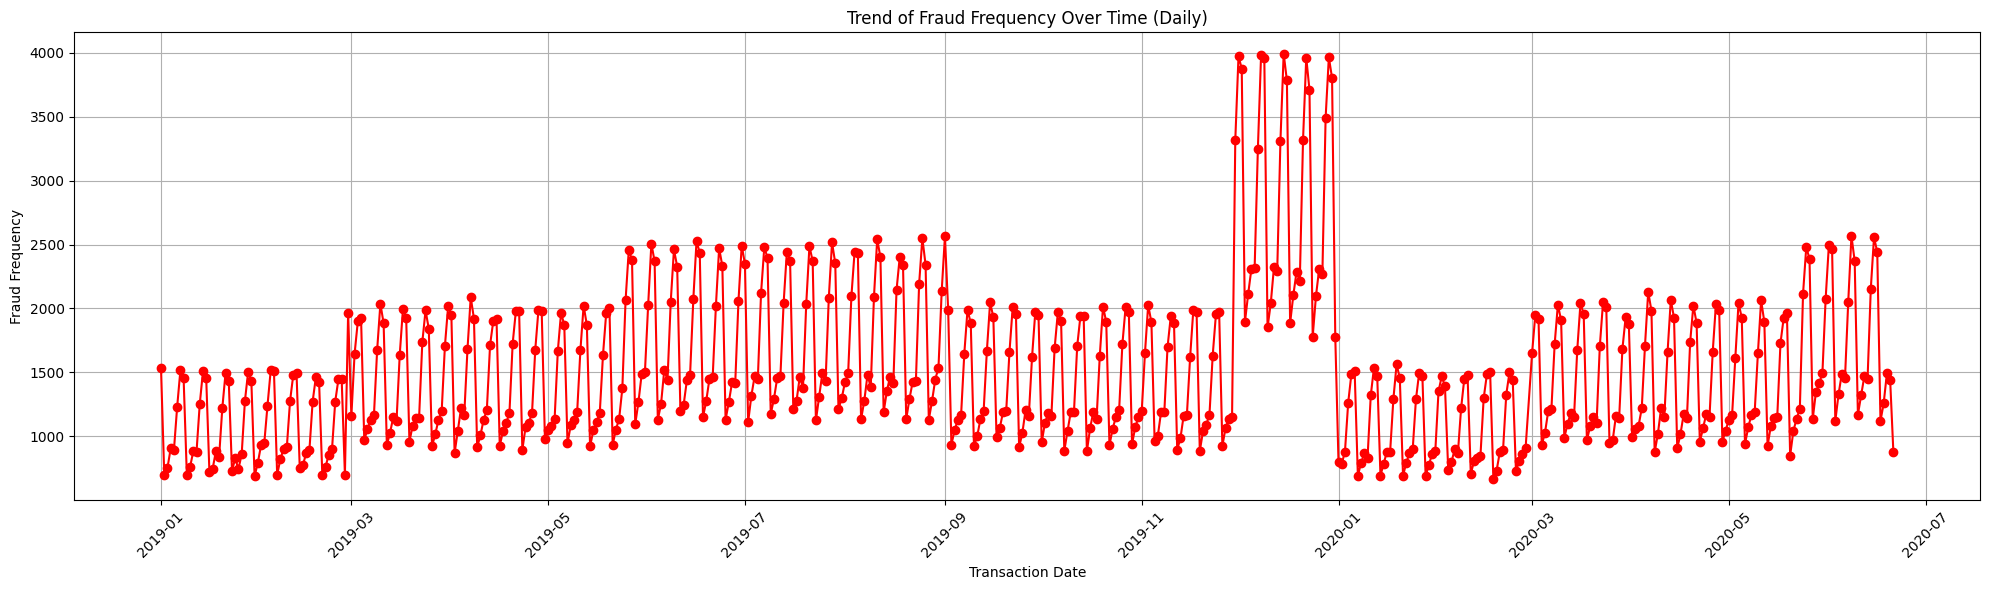

In [111]:
masked_df = masked_df.withColumn('transaction_date', F.to_date(F.col('transaction_date')))

fraud_frequency_trend = masked_df.groupBy('transaction_date').agg(F.count('amt').alias('fraud_frequency')).orderBy("transaction_date")
fraud_frequency_trend_pd = fraud_frequency_trend.toPandas()

plt.figure(figsize=(20, 6))
plt.plot(fraud_frequency_trend_pd['transaction_date'], fraud_frequency_trend_pd['fraud_frequency'], marker='o', color='red')
plt.title('Trend of Fraud Frequency Over Time (Daily)')
plt.xlabel('Transaction Date')
plt.ylabel('Fraud Frequency')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

The frequency of fraud in every two months are quite stable.

### How is the fraud amount trend overtime (daily)?

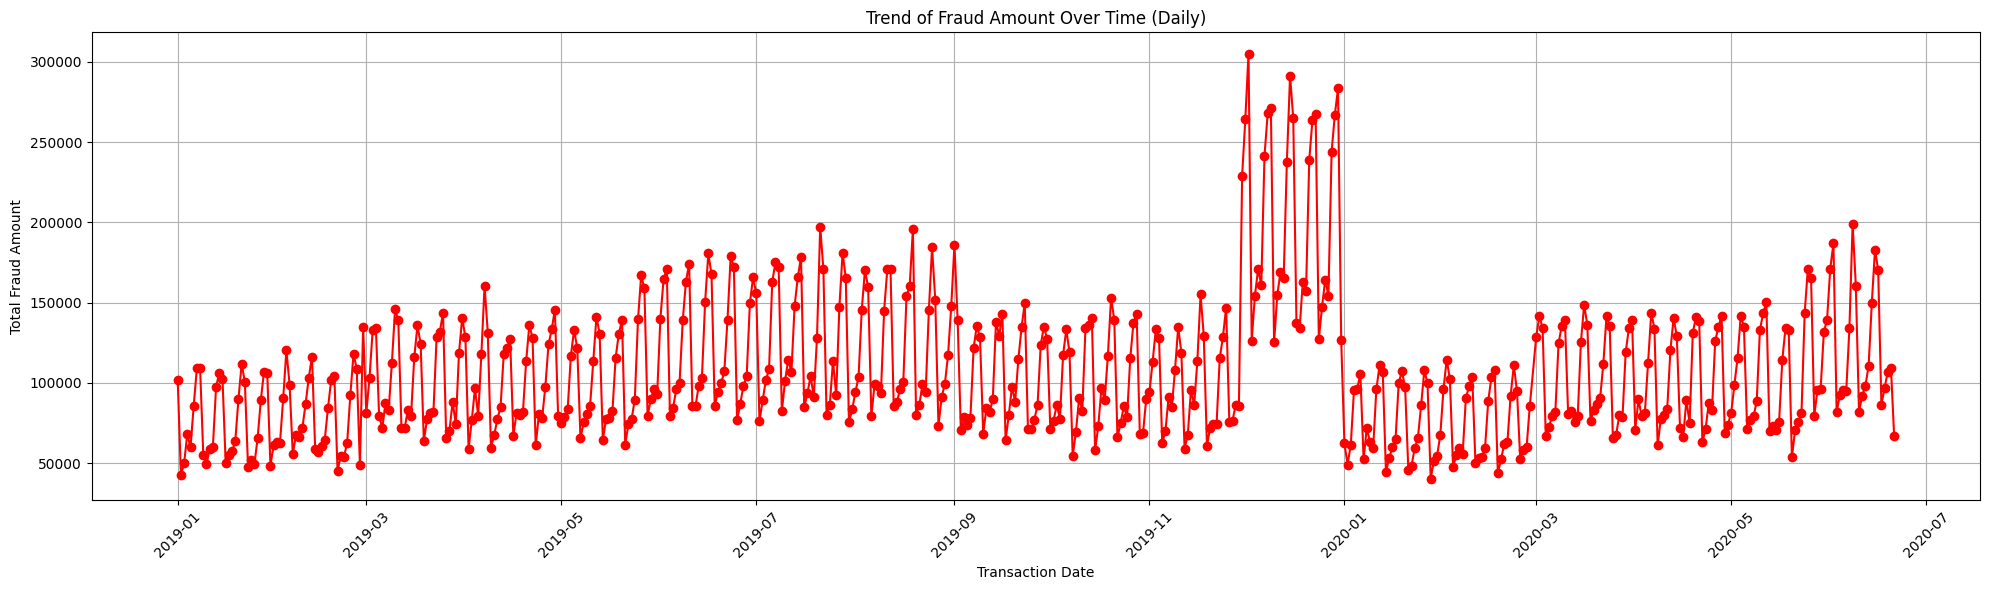

In [112]:
masked_df = masked_df.withColumn('transaction_date', F.to_date(F.col('transaction_date')))

fraud_trend = masked_df.groupBy('transaction_date').agg(F.sum('amt').alias('total_fraud_amount')).orderBy("transaction_date")

fraud_trend_pd = fraud_trend.toPandas()

plt.figure(figsize=(20, 6))
plt.plot(fraud_trend_pd['transaction_date'], fraud_trend_pd['total_fraud_amount'], marker='o', color='red')
plt.title('Trend of Fraud Amount Over Time (Daily)')
plt.xlabel('Transaction Date')
plt.ylabel('Total Fraud Amount')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

The transaction fraud amount in every two months are quite stable.

### How is the fraud frequency trend overtime (monthly)?

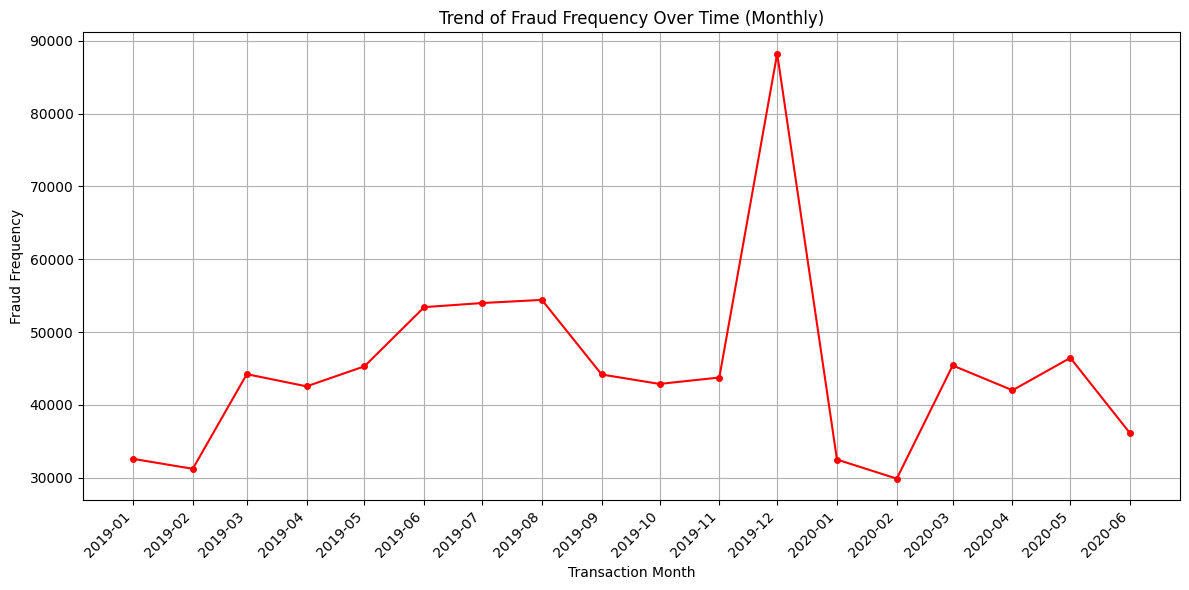

In [113]:
masked_df = masked_df.withColumn('transaction_date', F.to_date(F.col('transaction_date')))

fraud_frequency_trend = masked_df.groupBy(F.trunc('transaction_date', 'MM').alias('month')).agg(
    F.count('amt').alias('fraud_frequency')
).orderBy("month")

fraud_frequency_trend_pd = fraud_frequency_trend.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(fraud_frequency_trend_pd['month'], fraud_frequency_trend_pd['fraud_frequency'], marker='o', linestyle='-', markersize=4, color='red')

plt.title('Trend of Fraud Frequency Over Time (Monthly)')
plt.xlabel('Transaction Month')
plt.ylabel('Fraud Frequency')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Change interval for more or less ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year-Month

plt.xticks(rotation=45, ha='right')

plt.grid()

plt.tight_layout()

plt.show()

The highest frequency of fraud happened in December 2019.

### How is the fraud amount trend overtime (monthly)?

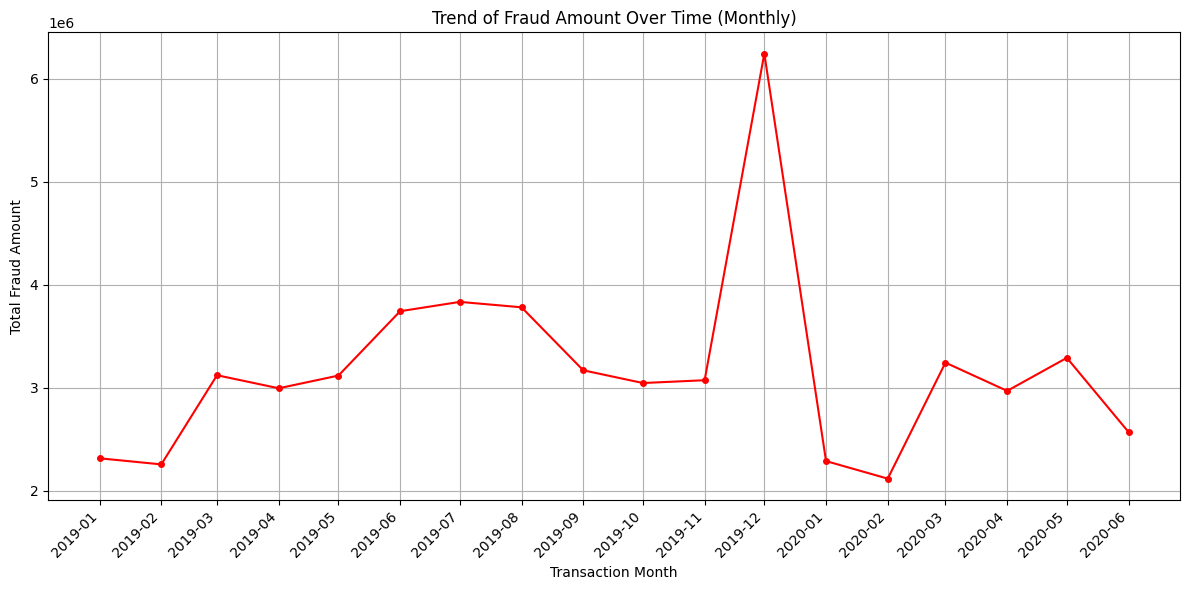

In [114]:
fraud_trend = masked_df.groupBy(F.trunc('transaction_date', 'MM').alias('month')).agg(
    F.sum('amt').alias('total_fraud_amount')
).orderBy("month")

fraud_trend_pd = fraud_trend.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(fraud_trend_pd['month'], fraud_trend_pd['total_fraud_amount'], marker='o', linestyle='-', markersize=4, color='red')

plt.title('Trend of Fraud Amount Over Time (Monthly)')
plt.xlabel('Transaction Month')
plt.ylabel('Total Fraud Amount')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Change interval for more or less ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year-Month

plt.xticks(rotation=45, ha='right')

plt.grid()

plt.tight_layout()

plt.show()

The highest transaction fraud amount happened in December 2019.

### How is the fraud frequency for each day of the week?

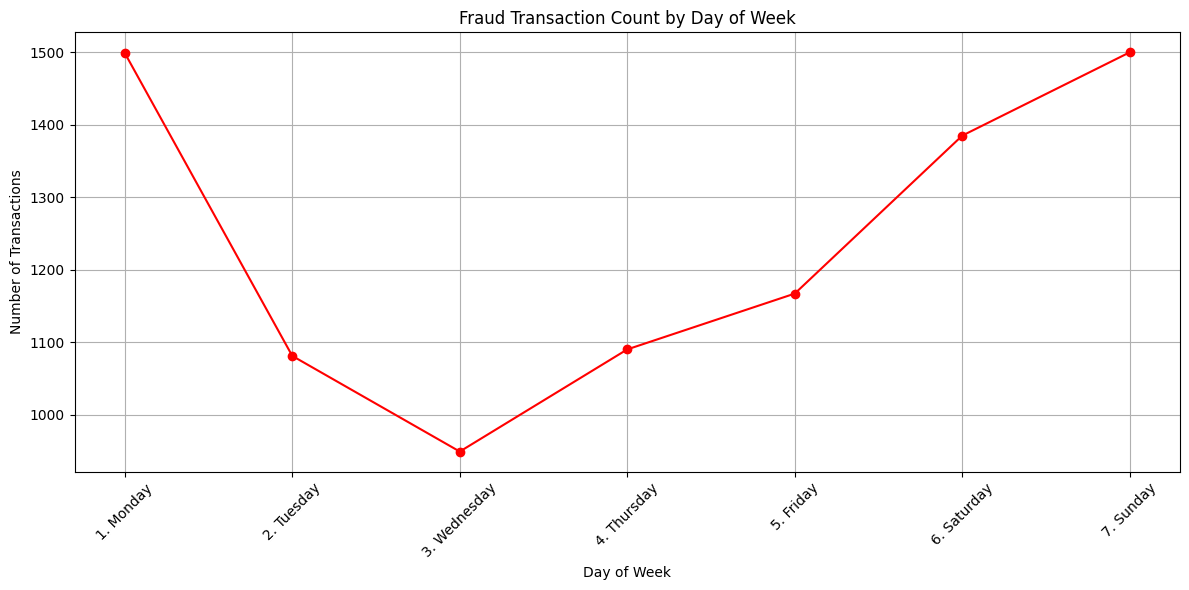

In [115]:
day_of_week_mapping = {
    1: '7. Sunday',
    2: '1. Monday',
    3: '2. Tuesday',
    4: '3. Wednesday',
    5: '4. Thursday',
    6: '5. Friday',
    7: '6. Saturday',
}

map_udf = F.udf(lambda x: day_of_week_mapping.get(x, None), StringType())

masked_df = masked_df.withColumn('day_name', map_udf(F.col('transaction_day_of_week')))

hourly_fraud_count = masked_df.groupBy("day_name", "is_fraud").count().toPandas()

hourly_fraud_count = hourly_fraud_count.sort_values("day_name")

hourly_fraud_pivot = hourly_fraud_count.pivot(index="day_name", columns="is_fraud", values="count").fillna(0)

plt.figure(figsize=(12, 6))
plt.plot(hourly_fraud_pivot.index, hourly_fraud_pivot[True], marker='o', label='Fraudulent Transactions', color='red')
plt.title("Fraud Transaction Count by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monday and Sunday has the highest fraud transaction.

### How is the fraud transaction amount for each day of the week?

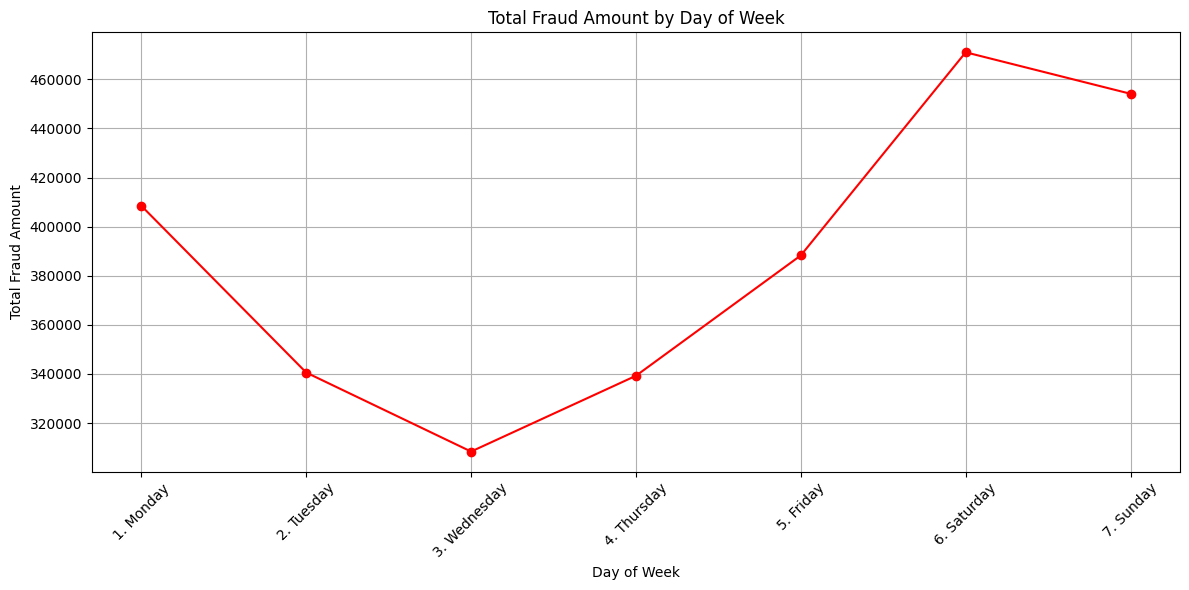

In [116]:
day_of_week_mapping = {
    1: '7. Sunday',
    2: '1. Monday',
    3: '2. Tuesday',
    4: '3. Wednesday',
    5: '4. Thursday',
    6: '5. Friday',
    7: '6. Saturday',
}

map_udf = F.udf(lambda x: day_of_week_mapping.get(x, None), StringType())

masked_df = masked_df.withColumn('day_name', map_udf(F.col('transaction_day_of_week')))

hourly_fraud_sum = masked_df.filter(F.col("is_fraud") == True).groupBy("day_name").agg(
    F.sum("amt").alias("total_fraud_amount")
).toPandas()

hourly_fraud_sum = hourly_fraud_sum.sort_values("day_name")

plt.figure(figsize=(12, 6))
plt.plot(hourly_fraud_sum["day_name"], hourly_fraud_sum['total_fraud_amount'], marker='o', label='Total Fraud Amount', color='red')
plt.title("Total Fraud Amount by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Fraud Amount")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Saturday and Sunday has the highest fraud transaction amount as it is holiday.

### How is the fraud frequency in every hour of the day?

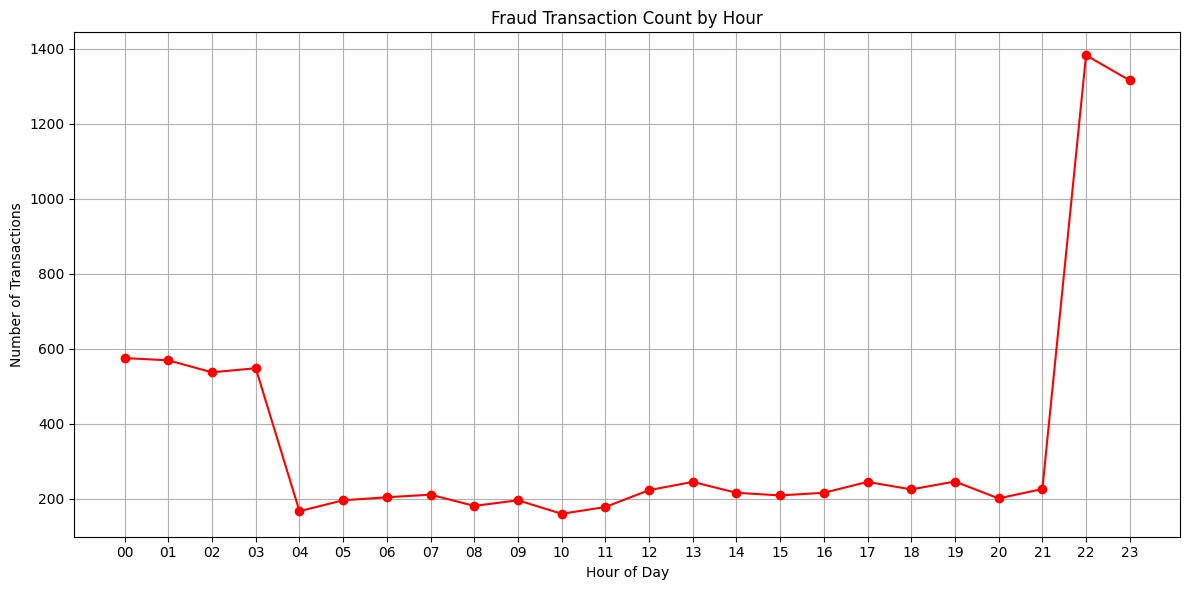

In [117]:
hourly_fraud_count = masked_df.groupBy("transaction_hour", "is_fraud").count().toPandas()

hourly_fraud_count = hourly_fraud_count.sort_values("transaction_hour")
hourly_fraud_pivot = hourly_fraud_count.pivot(index="transaction_hour", columns="is_fraud", values="count").fillna(0)

plt.figure(figsize=(12, 6))
plt.plot(hourly_fraud_pivot.index, hourly_fraud_pivot[True], marker='o', label='Fraudulent Transactions', color='red')
plt.title("Fraud Transaction Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

There are lots of fraud transactions during the midnight.

### How is the fraud transaction amount in every hour of the day?

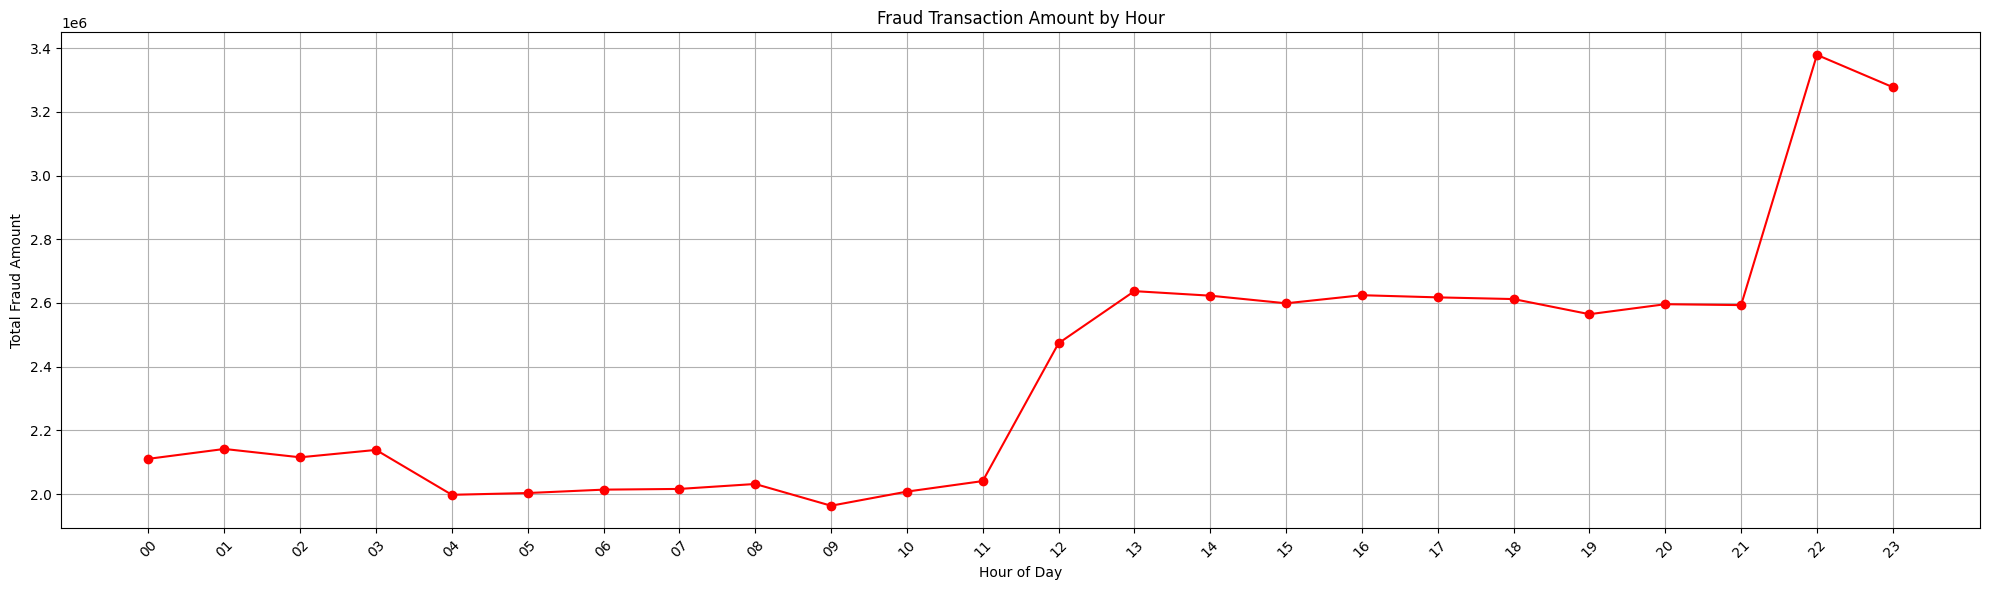

In [118]:
fraud_trend = masked_df.groupBy('transaction_hour').agg(F.sum('amt').alias('total_fraud_amount')).orderBy("transaction_hour")

fraud_trend_pd = fraud_trend.toPandas()

plt.figure(figsize=(20, 6))
plt.plot(fraud_trend_pd['transaction_hour'], fraud_trend_pd['total_fraud_amount'], marker='o', color='red')
plt.title('Fraud Transaction Amount by Hour')
plt.xlabel("Hour of Day")
plt.ylabel('Total Fraud Amount')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

The fraud amount keeps getting higher starting from 11 AM until 11 PM peaking in 11 PM.

### Which city has the highest number of fraud?

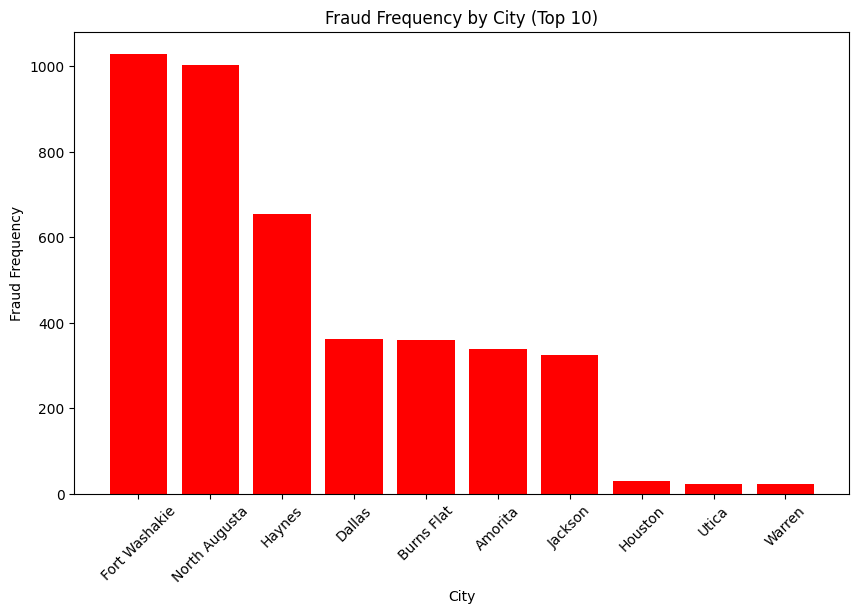

In [119]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("city") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .limit(10) \
    .collect()

plt.figure(figsize=(10, 6))
plt.bar([res["city"] for res in result], [res["sum(is_fraud_int)"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by City (Top 10)')

plt.show()

Fort Washakie and North Augusta has the highest number of fraud.

### Which city has the highest fraud ratio over total number transactions?

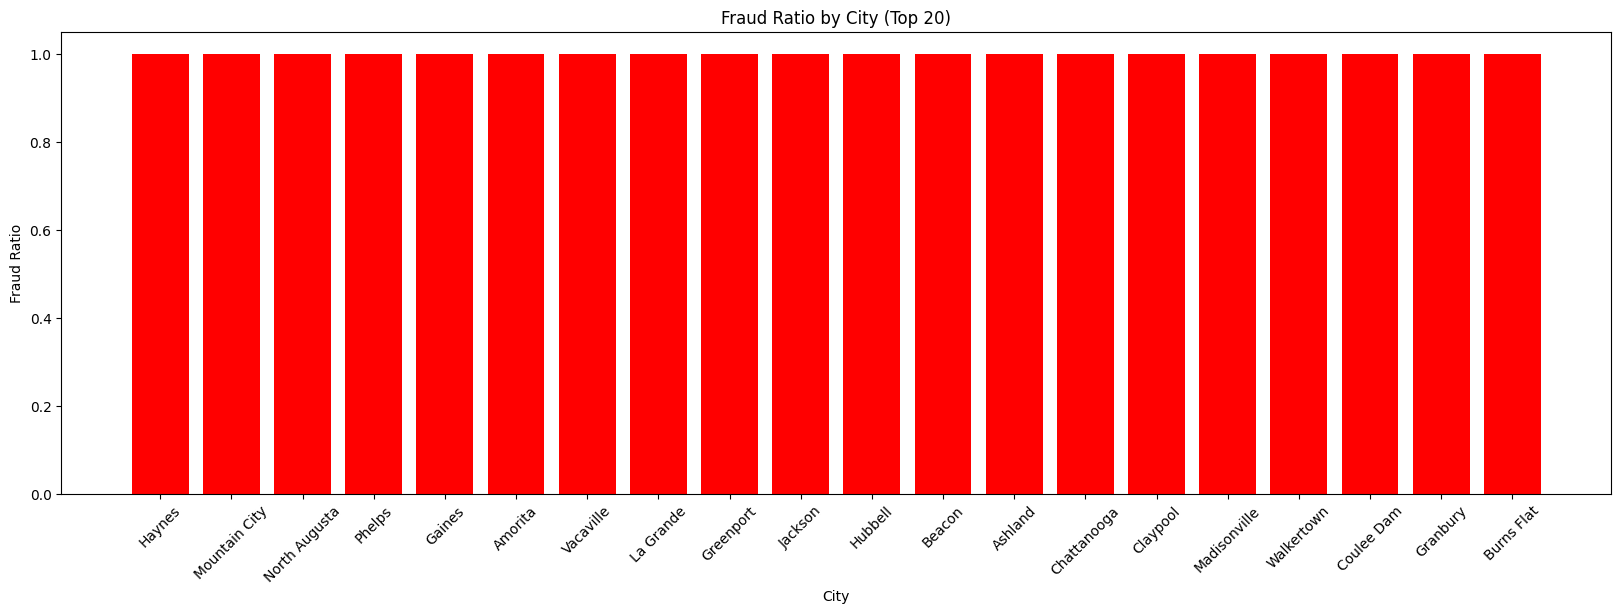

In [120]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("city") \
    .agg(
        F.sum("is_fraud_int").alias("fraud_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("fraud_ratio", F.col("fraud_count") / F.col("total_count")) \
    .orderBy(F.desc("fraud_ratio")) \
    .limit(20) \
    .collect()

plt.figure(figsize=(20, 6))
plt.bar([res["city"] for res in result], [res["fraud_ratio"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio by City (Top 20)')

plt.show()

The cities appear to be diverse in nature, including places like:

- Mountain areas (Mountain City)
- Smaller towns (Haynes, Phelps)
- Various regional centers (Madisonville, Grantbury)

### Does gender affect the probability of fraud?

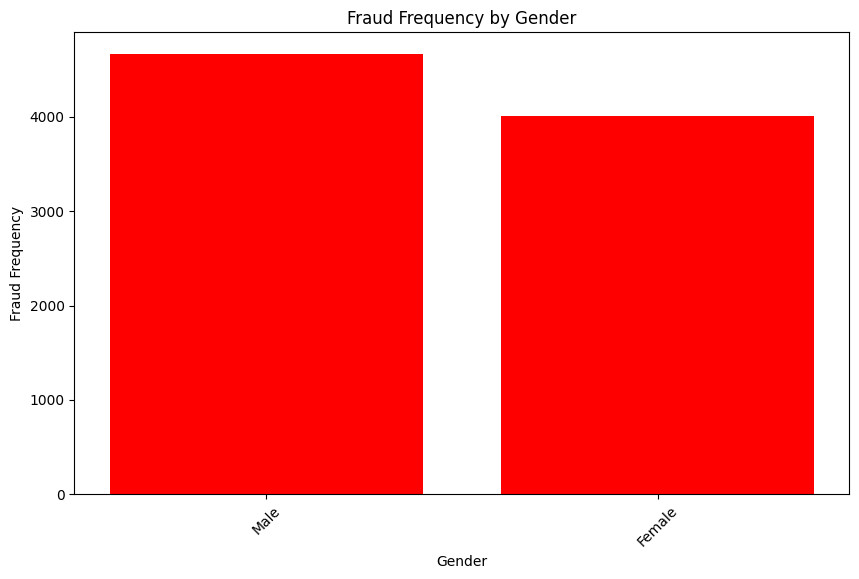

In [121]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("gender") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .collect()

plt.figure(figsize=(10, 6))
plt.bar([res["gender"] for res in result], [res["sum(is_fraud_int)"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Gender')

plt.show()

Male tends to do fraud compared to Female.

### Does gender affect the fraud ratio?

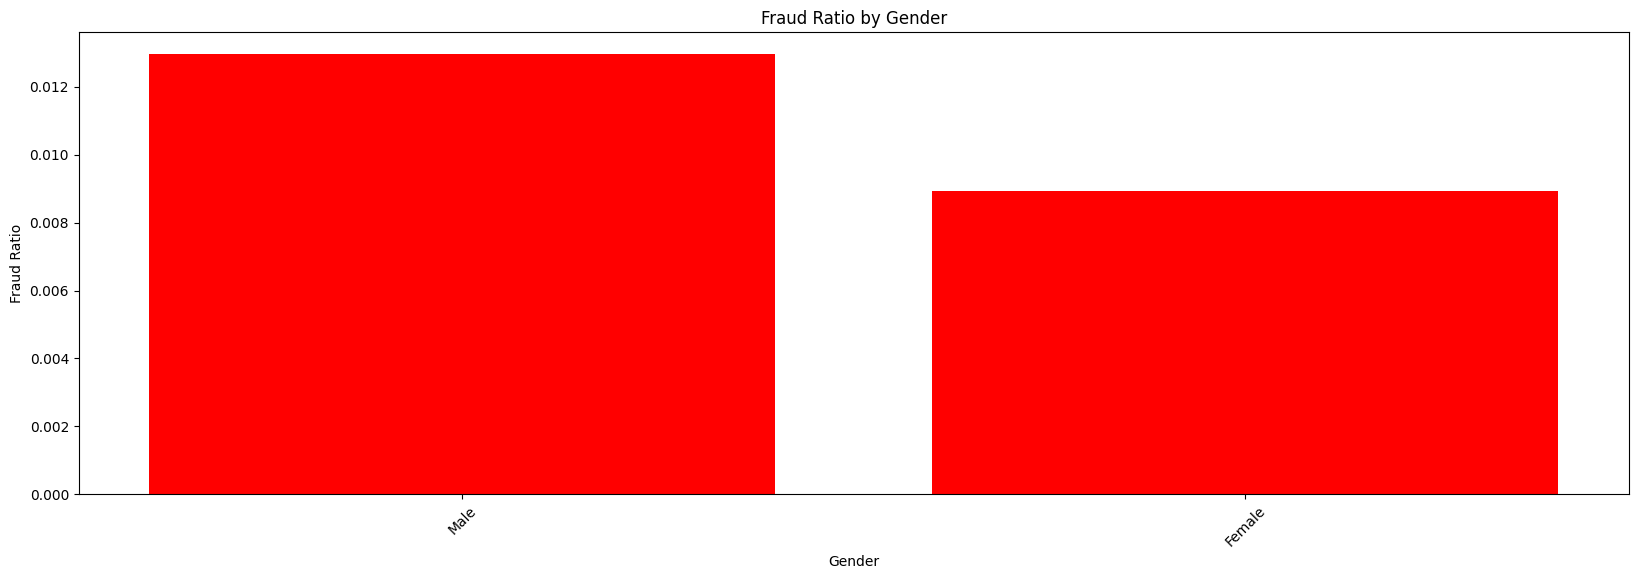

In [122]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("gender") \
    .agg(
        F.sum("is_fraud_int").alias("fraud_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("fraud_ratio", F.col("fraud_count") / F.col("total_count")) \
    .orderBy(F.desc("fraud_ratio")) \
    .collect()

plt.figure(figsize=(20, 6))
plt.bar([res["gender"] for res in result], [res["fraud_ratio"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio by Gender')

plt.show()

Based on the ratio from the data that we have, Male still have more tendency to do fraud.

### Which age group does fraud the most?

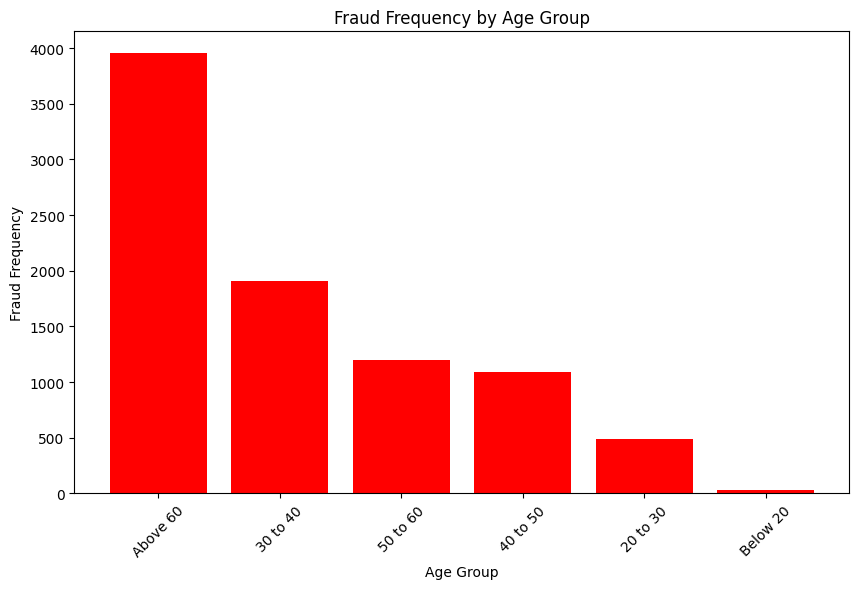

In [123]:
masked_df = masked_df.withColumn(
    "age_group",
    F.when(F.col("age") > 60, "Above 60")
     .when((F.col("age") > 50) & (F.col("age") <= 60), "50 to 60")
     .when((F.col("age") > 40) & (F.col("age") <= 50), "40 to 50")
     .when((F.col("age") > 30) & (F.col("age") <= 40), "30 to 40")
     .when((F.col("age") > 20) & (F.col("age") <= 30), "20 to 30")
     .otherwise("Below 20")
)

result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("age_group") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .collect()

age_groups = [res["age_group"] for res in result]
fraud_counts = [res["sum(is_fraud_int)"] for res in result]

plt.figure(figsize=(10, 6))
plt.bar(age_groups, fraud_counts, color='red')

plt.xticks(rotation=45)
plt.xlabel('Age Group')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Age Group')

plt.show()

Age above 60 does the highest fraud.

### Does age group affect the fraud ratio?

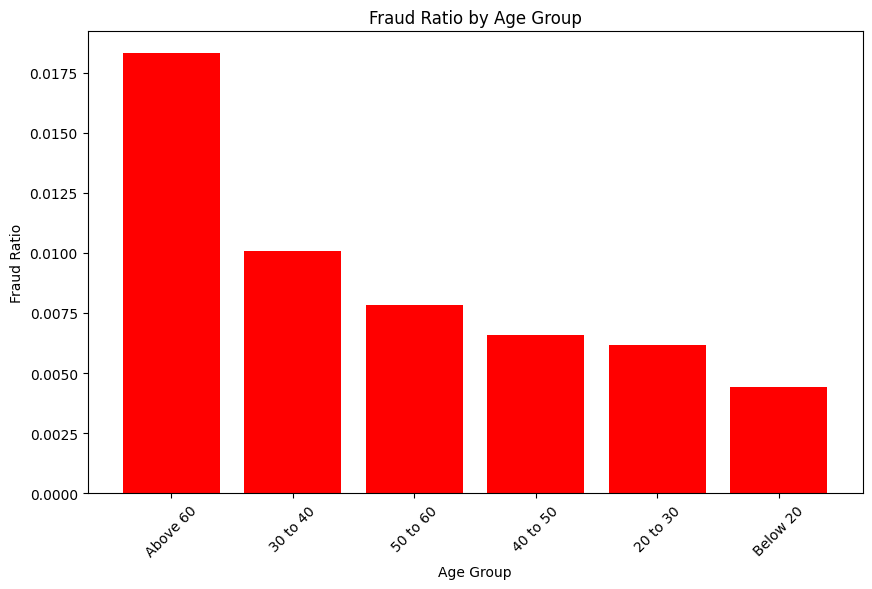

In [124]:
masked_df = masked_df.withColumn(
    "age_group",
    F.when(F.col("age") > 60, "Above 60")
     .when((F.col("age") > 50) & (F.col("age") <= 60), "50 to 60")
     .when((F.col("age") > 40) & (F.col("age") <= 50), "40 to 50")
     .when((F.col("age") > 30) & (F.col("age") <= 40), "30 to 40")
     .when((F.col("age") > 20) & (F.col("age") <= 30), "20 to 30")
     .otherwise("Below 20")
)

result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("age_group") \
    .agg(
        F.sum("is_fraud_int").alias("fraud_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("fraud_ratio", F.col("fraud_count") / F.col("total_count")) \
    .orderBy(F.desc("fraud_ratio")) \
    .collect()

age_groups = [res["age_group"] for res in result]
fraud_counts = [res["fraud_ratio"] for res in result]

plt.figure(figsize=(10, 6))
plt.bar(age_groups, fraud_counts, color='red')

plt.xticks(rotation=45)
plt.xlabel('Age Group')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio by Age Group')

plt.show()

Age above 60 has the highest fraud ratio which aligns with the frequency of fraud. Older adults may face financial pressures due to retirement, fixed incomes, or unexpected medical expenses. This vulnerability can make them more susceptible to fraud, either as perpetrators seeking quick financial relief or as victims of scams.

### Which job does fraud the most?

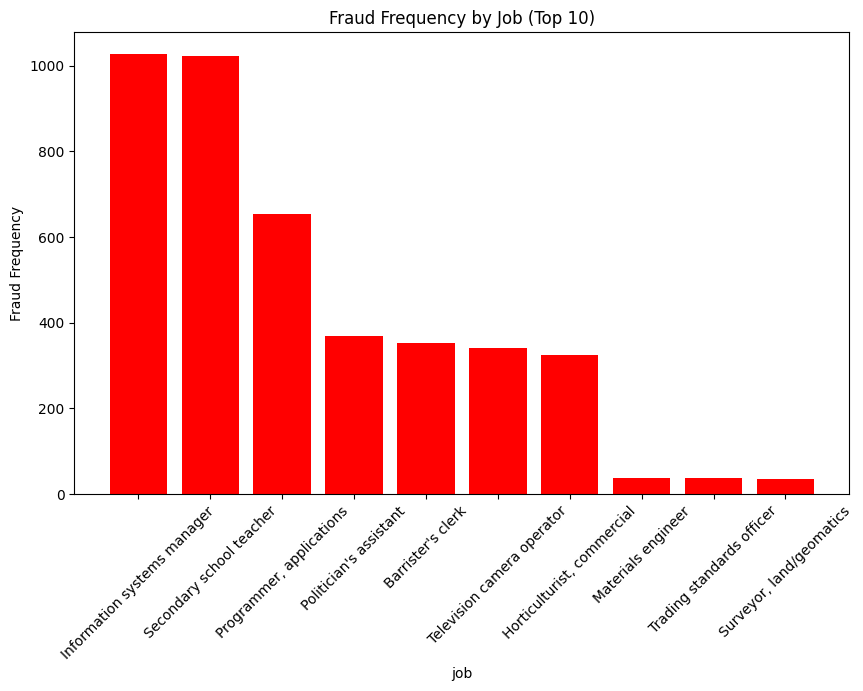

In [125]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("job") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .limit(10) \
    .collect()

plt.figure(figsize=(10, 6))
plt.bar([res["job"] for res in result], [res["sum(is_fraud_int)"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('job')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Job (Top 10)')

plt.show()

Information systems managers and secondary school teachers exhibit notably higher frequencies of fraud, each with around 1,000 reported cases. Those in tech-related roles may exploit their access to technology and databases to commit fraudulent acts. Meanwhile, education professionals might resort to fraud due to insufficient salaries that make it difficult for them to make ends meet.

### Does job affect the fraud ratio?

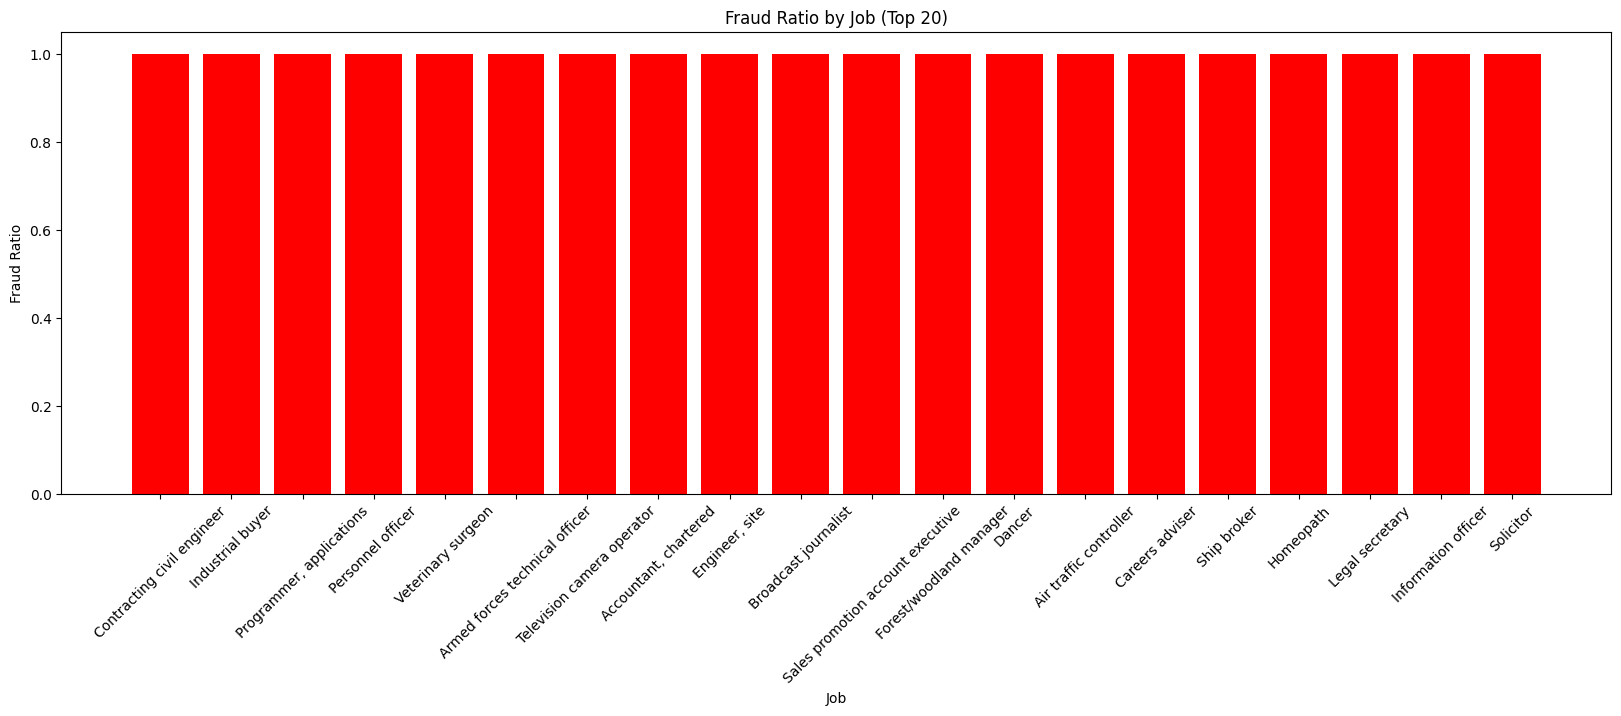

In [126]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("job") \
    .agg(
        F.sum("is_fraud_int").alias("fraud_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("fraud_ratio", F.col("fraud_count") / F.col("total_count")) \
    .orderBy(F.desc("fraud_ratio")) \
    .limit(20) \
    .collect()

plt.figure(figsize=(20, 6))
plt.bar([res["job"] for res in result], [res["fraud_ratio"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('Job')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio by Job (Top 20)')

plt.show()

The jobs which has high probability on doing frauds:

- Technical roles (Programmer, Information officer)
- Professional services (Solicitor, Legal secretary)
- Medical (Veterinary surgeon)
- Engineering (Contracting civil engineer)
- Transportation (Air traffic controller, Ship broker)
- Media (Broadcast journalist)
- Security (Armed forces technical officer)

## Which merchant category involved in the fraud mostly?

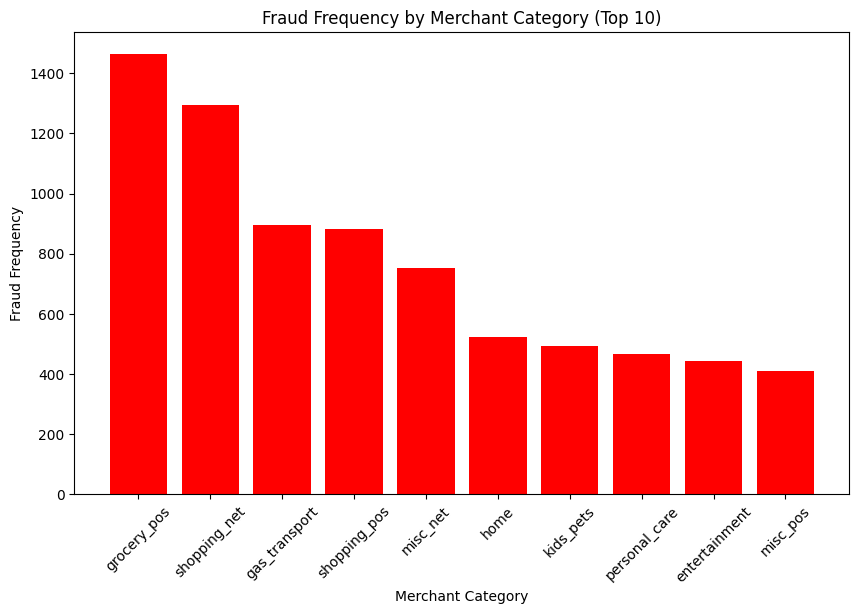

In [127]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("category") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .limit(10) \
    .collect()

plt.figure(figsize=(10, 6))
plt.bar([res["category"] for res in result], [res["sum(is_fraud_int)"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('Merchant Category')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Merchant Category (Top 10)')

plt.show()

Grocery Pos has the highest fraud frequency.

## Which merchant involved in the fraud mostly?

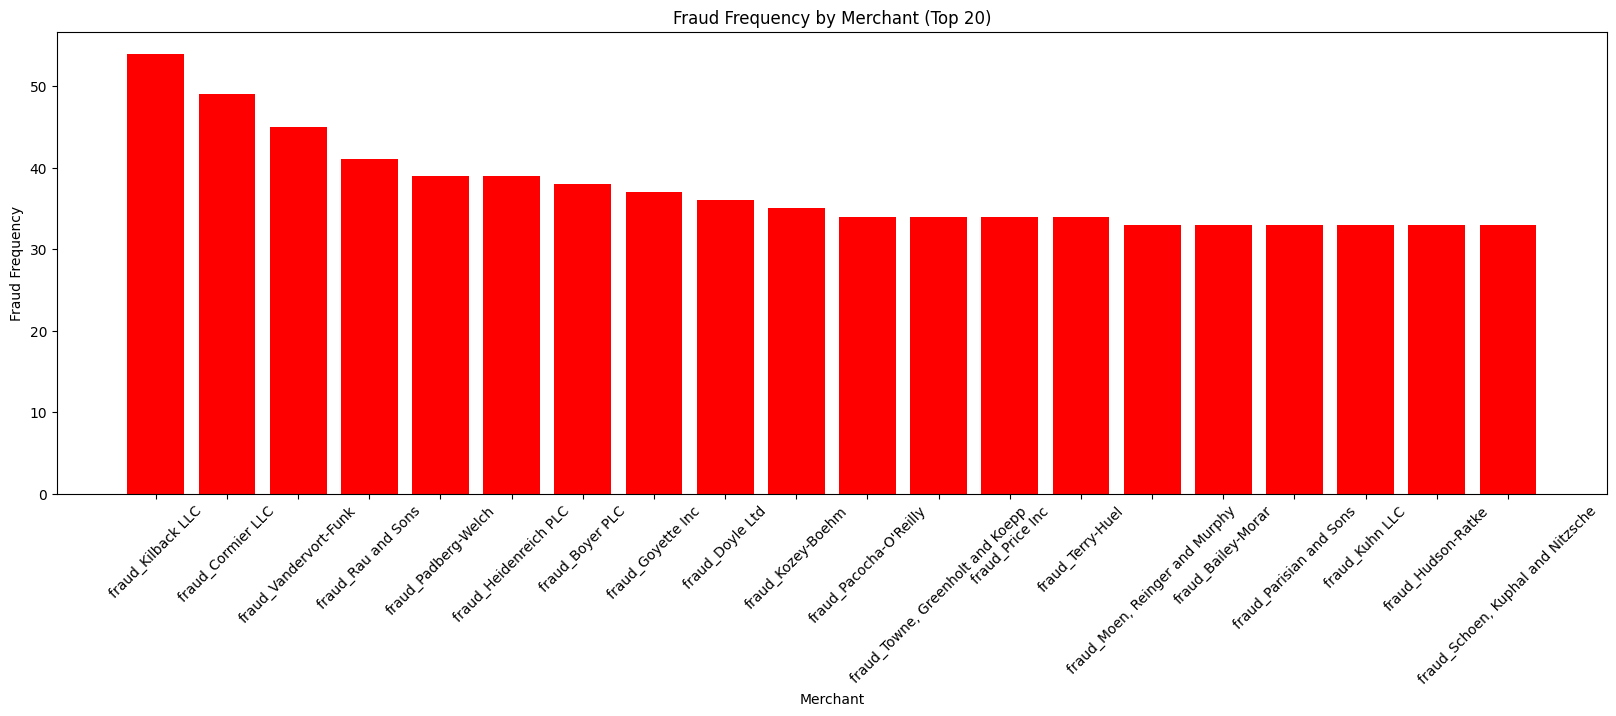

In [128]:
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("merchant") \
    .sum("is_fraud_int") \
    .orderBy(F.desc("sum(is_fraud_int)")) \
    .limit(20) \
    .collect()

plt.figure(figsize=(20, 6))
plt.bar([res["merchant"] for res in result], [res["sum(is_fraud_int)"] for res in result], color='red')

plt.xticks(rotation=45)
plt.xlabel('Merchant')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Merchant (Top 20)')

plt.show()

Every merchant with 'fraud' keyword has indication of fraud.

## Does distance from customer to merchant correlates with the fraud frequency?

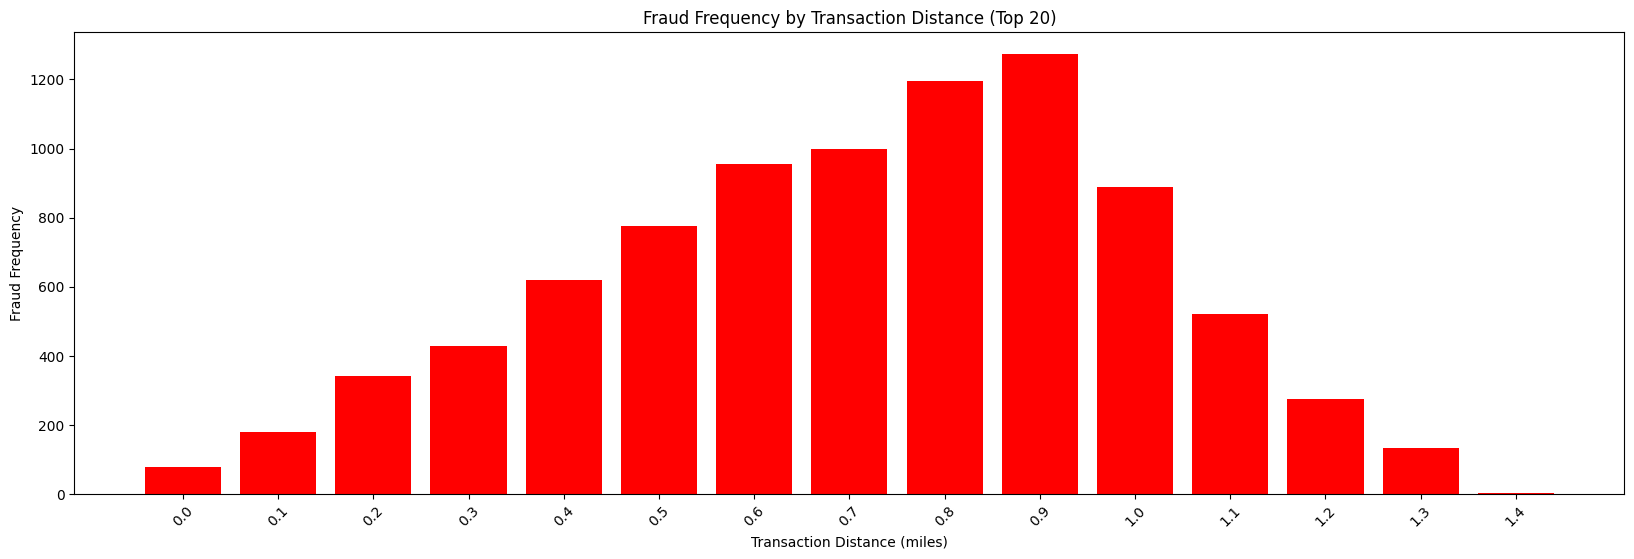

In [129]:
masked_df = masked_df.withColumn("distance_range", (F.floor(F.col("transaction_distance") * 10) / 10).cast(StringType()))

# Group by the new distance range and sum the fraud counts
result = masked_df.withColumn("is_fraud_int", F.col("is_fraud").cast("int")) \
    .groupBy("distance_range") \
    .sum("is_fraud_int") \
    .orderBy("distance_range") \
    .limit(20) \
    .collect()

# Prepare data for plotting
distance_labels = [res["distance_range"] for res in result]
fraud_frequencies = [res["sum(is_fraud_int)"] for res in result]

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(distance_labels, fraud_frequencies, color='red')

plt.xticks(rotation=45)
plt.xlabel('Transaction Distance (miles)')
plt.ylabel('Fraud Frequency')
plt.title('Fraud Frequency by Transaction Distance (Top 20)')

plt.show()

The data reveals that fraudulent transaction distances are negatively skewed, primarily falling within the range of 0 to 1.4 miles, with the mode occurring around 0.95 miles.